In [57]:

import numpy as np
import time as tm
import datetime as dt
import tensorflow as tf

# Data preparation
from yahoo_fin import stock_info as yf
from sklearn.preprocessing import MinMaxScaler
from collections import deque

# AI
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout

# Graphics library
import matplotlib.pyplot as plt

2025-07-06 20:46:50.594532: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Warning - Certain functionality 
             requires requests_html, which is not installed.
             
             Install using: 
             pip install requests_html
             
             After installation, you may have to restart your Python session.


In [17]:
pip install yfinance --upgrade

  Using cached websockets-15.0.1-cp312-cp312-macosx_10_13_x86_64.whl.metadata (6.8 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.7/5.7 MB 3.2 MB/s eta 0:00:00a 0:00:010m
Using cached websockets-15.0.1-cp312-cp312-macosx_10_13_x86_64.whl (173 kB)
  Attempting uninstall: websockets
    Found existing installation: websockets 10.4
    Uninstalling websockets-10.4:
      Successfully uninstalled websockets-10.4
  Attempting uninstall: yfinance
    Found existing installation: yfinance 0.2.54
    Uninstalling yfinance-0.2.54:
      Successfully uninstalled yfinance-0.2.54
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
polygon-api-client 1.14.6 requires websockets<15.0,>=10.3, but you have websockets 15.0.1 which is incompatible.
pyppeteer 2.0.0 requires websockets<11.0,>=10.0, but you have websockets 15.0.1 which is incompatible.
Note: you may need to restart t

In [1]:
import yfinance as yf
import datetime as dt

# SETTINGS
N_STEPS = 7  # 1 week window
LOOKUP_STEPS = [1, 2, 3]
STOCK = 'GOOGL'  # or try 'GOOG' if this fails

# Date range (3 years back from today)
end_date = dt.datetime.now()
start_date = end_date - dt.timedelta(days=1104)  # ~3 years

# Download data
try:
    df = yf.download(
        STOCK,
        start=start_date.strftime('%Y-%m-%d'),
        end=end_date.strftime('%Y-%m-%d'),
        interval='1d'
    )
    
    if df.empty:
        print(f"No data found for {STOCK}. Try a different ticker.")
    else:
        print(f"Successfully downloaded {len(df)} days of data for {STOCK}")
        print(df.head())
        
except Exception as e:
    print(f"Error downloading data: {e}")

/var/folders/tb/6mz71wqd5zjdgj1f0dtrpk640000gn/T/ipykernel_8210/1638332471.py:15: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(
[*********************100%***********************]  1 of 1 completed

Successfully downloaded 757 days of data for GOOGL
Price            Close        High         Low        Open    Volume
Ticker           GOOGL       GOOGL       GOOGL       GOOGL     GOOGL
Date                                                                
2022-06-28  111.339752  116.610146  111.181203  115.112126  35792000
2022-06-29  111.035576  112.485877  110.211516  110.886969  24716000
2022-06-30  108.313408  110.226935  106.113603  109.344228  43170000
2022-07-01  108.089249  108.598690  106.094210  107.289540  35476000
2022-07-05  112.587776  112.701095  105.101174  106.462016  39342000


In [49]:
# remove columns which our neural network will not use
#df = df.drop(columns=['Open', 'High', 'Low', 'Adj Close', 'Volume'], errors='ignore')
#df = df.drop(columns=['Ticker'], errors='ignore')
#df=df.reset_index()
#df.columns=['Date','Close']
#df=df.set_index('Date')
df
# remove columns which our neural network will not use
init_df = init_df.drop(['open', 'high', 'low', 'adjclose', 'ticker', 'volume'], axis=1)
# create the column 'date' based on index column
init_df['date'] = init_df.index



,Close
Date,
2022-06-28,111.339752
2022-06-29,111.035576
2022-06-30,108.313408
2022-07-01,108.089249
2022-07-05,112.587776
...,...
2025-06-27,178.529999
2025-06-30,176.229996
2025-07-01,175.839996


In [105]:
init_df.tail()

,close,date,scaled_close
Date,,,
2025-06-27,178.529999,2025-06-27,0.777463
2025-06-30,176.229996,2025-06-30,0.758758
2025-07-01,175.839996,2025-07-01,0.755586
2025-07-02,178.639999,2025-07-02,0.778357
2025-07-03,179.529999,2025-07-03,0.785595


In [60]:
init_df.columns=['close','date']

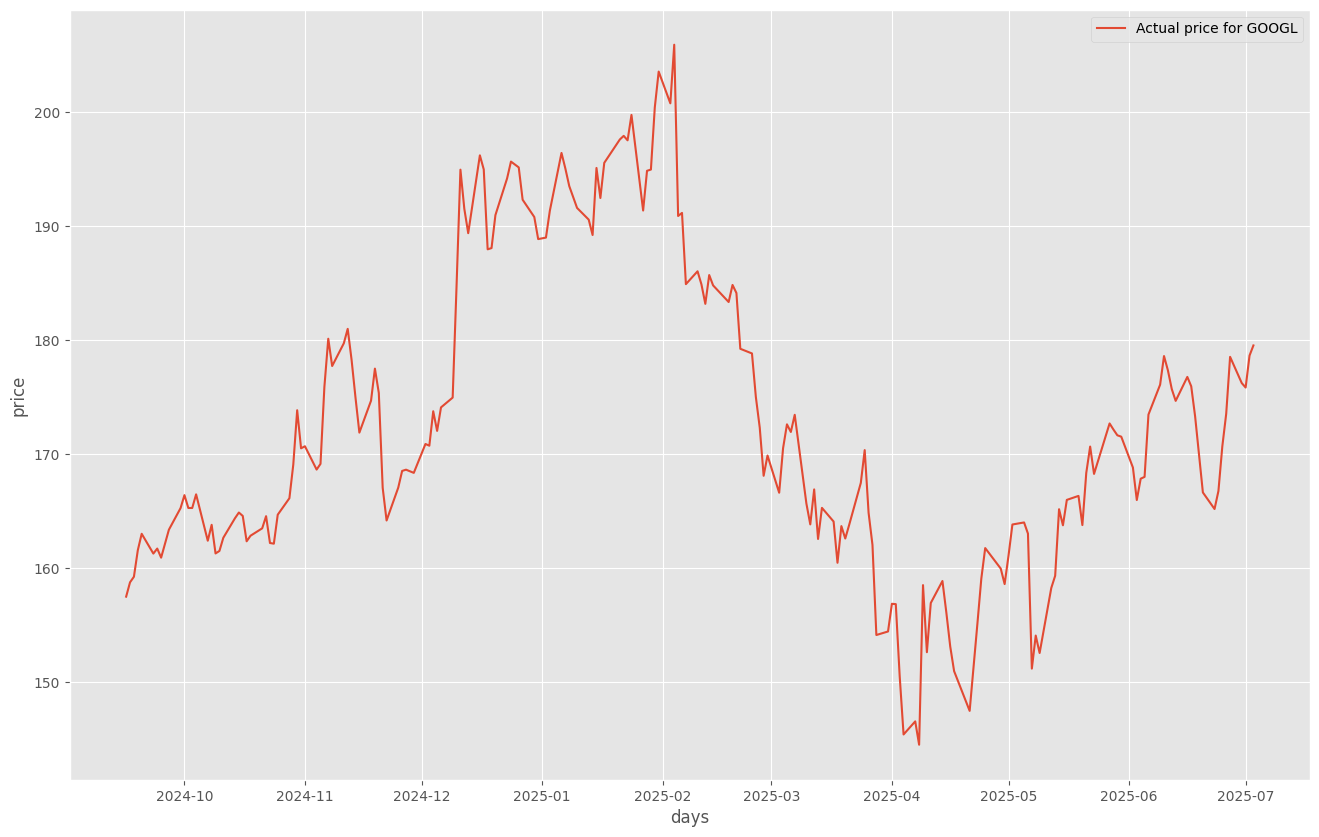

In [62]:
# Let's preliminary see our data on the graphic
plt.style.use(style='ggplot')
plt.figure(figsize=(16,10))
plt.plot(init_df['close'][-200:])
plt.xlabel('days')
plt.ylabel('price')
plt.legend([f'Actual price for {STOCK}'])
plt.show()

In [64]:
scaler = MinMaxScaler()
init_df['scaled_close'] = scaler.fit_transform(np.expand_dims(init_df['close'].values, axis=1))

In [66]:
def PrepareData(days):
  df = init_df.copy()
  df['future'] = df['scaled_close'].shift(-days)
  last_sequence = np.array(df[['scaled_close']].tail(days))
  df.dropna(inplace=True)
  sequence_data = []
  sequences = deque(maxlen=N_STEPS)

  for entry, target in zip(df[['scaled_close'] + ['date']].values, df['future'].values):
      sequences.append(entry)
      if len(sequences) == N_STEPS:
          sequence_data.append([np.array(sequences), target])

  last_sequence = list([s[:len(['scaled_close'])] for s in sequences]) + list(last_sequence)
  last_sequence = np.array(last_sequence).astype(np.float32)

  # construct the X's and Y's
  X, Y = [], []
  for seq, target in sequence_data:
      X.append(seq)
      Y.append(target)

  # convert to numpy arrays
  X = np.array(X)
  Y = np.array(Y)

  return df, last_sequence, X, Y

In [68]:
def GetTrainedModel(x_train, y_train):
  model = Sequential()
  model.add(LSTM(60, return_sequences=True, input_shape=(N_STEPS, len(['scaled_close']))))
  model.add(Dropout(0.3))
  model.add(LSTM(120, return_sequences=False))
  model.add(Dropout(0.3))
  model.add(Dense(20))
  model.add(Dense(1))

  BATCH_SIZE = 8
  EPOCHS = 80

  model.compile(loss='mean_squared_error', optimizer='adam')

  model.fit(x_train, y_train,
            batch_size=BATCH_SIZE,
            epochs=EPOCHS,
            verbose=1)

  model.summary()

  return model

In [70]:
# GET PREDICTIONS
predictions = []

for step in LOOKUP_STEPS:
  df, last_sequence, x_train, y_train = PrepareData(step)
  x_train = x_train[:, :, :len(['scaled_close'])].astype(np.float32)

  model = GetTrainedModel(x_train, y_train)

  last_sequence = last_sequence[-N_STEPS:]
  last_sequence = np.expand_dims(last_sequence, axis=0)
  prediction = model.predict(last_sequence)
  predicted_price = scaler.inverse_transform(prediction)[0][0]

  predictions.append(round(float(predicted_price), 2))

/opt/anaconda3/envs/myenv/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/80
94/94 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - loss: 0.0509
Epoch 2/80
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0037
Epoch 3/80
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0034
Epoch 4/80
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0035
Epoch 5/80
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0024
Epoch 6/80
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0031
Epoch 7/80
94/94 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.0028
Epoch 8/80
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0026
Epoch 9/80
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0024
Epoch 10/80
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0026
Epoch 11/80
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0026
Epoch 12/80
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0021
Epoch 13/80
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0023
Epoch 14/80
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0021
Epoch 15/80
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0019
Epoch 16/80
94/94 

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 7, 60)          │        14,880 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 7, 60)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 120)            │        86,880 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 120)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 20)             │         2,420 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            21 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 312,605 (1.19 MB)

 Trainable params: 104,201 (407.04 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 208,404 (814.08 KB)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 424ms/step
Epoch 1/80


/opt/anaconda3/envs/myenv/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


94/94 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - loss: 0.0484
Epoch 2/80
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0048
Epoch 3/80
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0037
Epoch 4/80
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0052
Epoch 5/80
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0037
Epoch 6/80
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0038
Epoch 7/80
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0035
Epoch 8/80
94/94 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.0031
Epoch 9/80
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0032
Epoch 10/80
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0029
Epoch 11/80
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0034
Epoch 12/80
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0024
Epoch 13/80
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0024
Epoch 14/80
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0027
Epoch 15/80
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0025
Epoch 16/80
94/94 ━━━━━━━━━━━

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_2 (LSTM)                   │ (None, 7, 60)          │        14,880 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 7, 60)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 120)            │        86,880 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 120)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 20)             │         2,420 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            21 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 312,605 (1.19 MB)

 Trainable params: 104,201 (407.04 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 208,404 (814.08 KB)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 341ms/step
Epoch 1/80


/opt/anaconda3/envs/myenv/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


94/94 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 0.0613
Epoch 2/80
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0043
Epoch 3/80
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0044
Epoch 4/80
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0041
Epoch 5/80
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0045
Epoch 6/80
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0035
Epoch 7/80
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0035
Epoch 8/80
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0036
Epoch 9/80
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0030
Epoch 10/80
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0033
Epoch 11/80
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0031
Epoch 12/80
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0029
Epoch 13/80
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0029
Epoch 14/80
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0029
Epoch 15/80
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0031
Epoch 16/80
94/94 ━━━━━━━━━━━━

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_4 (LSTM)                   │ (None, 7, 60)          │        14,880 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 7, 60)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_5 (LSTM)                   │ (None, 120)            │        86,880 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 120)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 20)             │         2,420 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │            21 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 312,605 (1.19 MB)

 Trainable params: 104,201 (407.04 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 208,404 (814.08 KB)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 279ms/step


In [72]:
if bool(predictions) == True and len(predictions) > 0:
  predictions_list = [str(d)+'$' for d in predictions]
  predictions_str = ', '.join(predictions_list)
  message = f'{STOCK} prediction for upcoming 3 days ({predictions_str})'
  
  print(message)

GOOGL prediction for upcoming 3 days (177.3$, 176.68$, 176.53$)


In [74]:
# Execute model for the whole history range
copy_df = init_df.copy()
y_predicted = model.predict(x_train)
y_predicted_transformed = np.squeeze(scaler.inverse_transform(y_predicted))
first_seq = scaler.inverse_transform(np.expand_dims(y_train[:6], axis=1))
last_seq = scaler.inverse_transform(np.expand_dims(y_train[-3:], axis=1))
y_predicted_transformed = np.append(first_seq, y_predicted_transformed)
y_predicted_transformed = np.append(y_predicted_transformed, last_seq)
copy_df[f'predicted_close'] = y_predicted_transformed

24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step


In [76]:
# Add predicted results to the table
date_now = dt.date.today()
date_tomorrow = dt.date.today() + dt.timedelta(days=1)
date_after_tomorrow = dt.date.today() + dt.timedelta(days=2)

copy_df.loc[date_now] = [predictions[0], f'{date_now}', 0, 0]
copy_df.loc[date_tomorrow] = [predictions[1], f'{date_tomorrow}', 0, 0]
copy_df.loc[date_after_tomorrow] = [predictions[2], f'{date_after_tomorrow}', 0, 0]

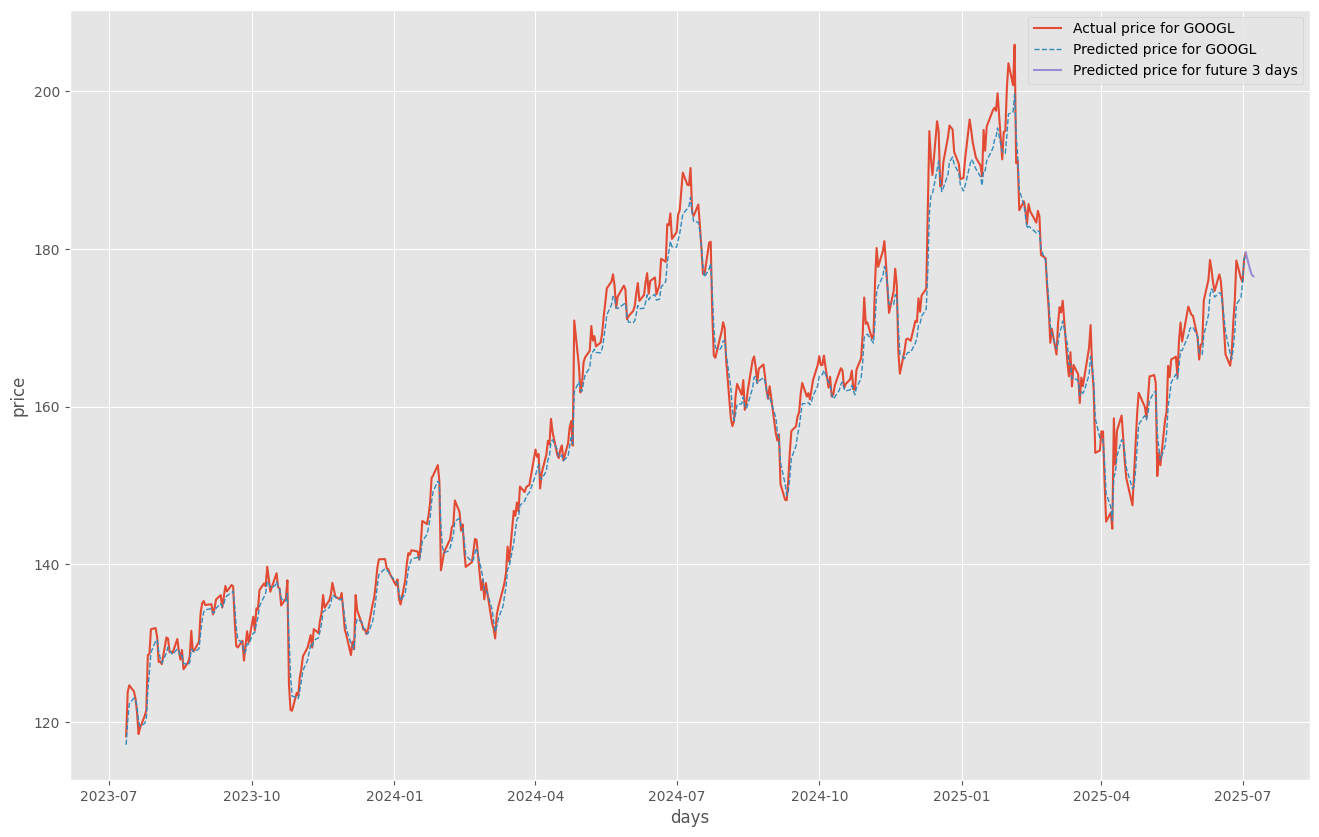

In [93]:
# Result chart
plt.style.use(style='ggplot')
plt.figure(figsize=(16,10))
plt.plot(copy_df['close'][-500:].head(497))
plt.plot(copy_df['predicted_close'][-500:].head(497), linewidth=1, linestyle='dashed')
plt.plot(copy_df['close'][-500:].tail(4))
plt.xlabel('days')
plt.ylabel('price')
plt.legend([f'Actual price for {STOCK}', 
            f'Predicted price for {STOCK}',
            f'Predicted price for future 3 days'])
plt.show()

In [99]:
copy_df.tail(10)

,close,date,scaled_close,predicted_close
Date,,,,
2025-06-25 00:00:00,170.679993,2025-06-25 00:00:00,0.713621,167.450104
2025-06-26 00:00:00,173.539993,2025-06-26 00:00:00,0.736881,169.572021
2025-06-27 00:00:00,178.529999,2025-06-27 00:00:00,0.777463,172.967148
2025-06-30 00:00:00,176.229996,2025-06-30 00:00:00,0.758758,173.827148
2025-07-01 00:00:00,175.839996,2025-07-01 00:00:00,0.755586,175.839996
2025-07-02 00:00:00,178.639999,2025-07-02 00:00:00,0.778357,178.639999
2025-07-03 00:00:00,179.529999,2025-07-03 00:00:00,0.785595,179.529999
2025-07-06,177.300000,2025-07-06,0.000000,0.000000
2025-07-07,176.680000,2025-07-07,0.000000,0.000000


In [103]:
[predictions[0], f'{date_now}', 0, 0]

[177.3, '2025-07-06', 0, 0]

In [ ]:
import numpy as np
import pandas as pd
import yfinance as yf
import datetime as dt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt

# Settings
N_STEPS = 20  # Increased window size for better pattern recognition
LOOKUP_STEPS = [1, 2, 3, 5, 7]  # Multiple prediction horizons
STOCK = 'GOOGL'
TEST_SIZE = 0.2
UNITS = 128  # LSTM units
DROPOUT = 0.3  # Dropout rate
BATCH_SIZE = 64
EPOCHS = 200  # Will use early stopping
LEARNING_RATE = 0.001

# Date range (3 years back from today)
end_date = dt.datetime.now()
start_date = end_date - dt.timedelta(days=1104)

# Download data
try:
    df = yf.download(
        STOCK,
        start=start_date.strftime('%2007-%01-%d'),
        end=end_date.strftime('%Y-%m-%d'),
        interval='1d'
    )
    
    if df.empty:
        print(f"No data found for {STOCK}. Try a different ticker.")
    else:
        print(f"Successfully downloaded {len(df)} days of data for {STOCK}")
        print(df.head())
        
except Exception as e:
    print(f"Error downloading data: {e}")
    exit()

# Keep only the 'Close' column for simplicity (we'll add more features)
df = df[['Close']]


In [3]:
df

Price,Close,SMA_10,SMA_30,Volatility,RSI,MACD,Signal,MACD_Hist,Middle_Band
Ticker,GOOGL,,,,,,,,
Date,,,,,,,,,
2022-06-28,111.339760,NaN,NaN,NaN,NaN,0.000000,0.000000,0.000000,NaN
2022-06-29,111.035591,NaN,NaN,NaN,NaN,-0.024264,-0.004853,-0.019411,NaN
2022-06-30,108.313408,NaN,NaN,NaN,NaN,-0.260152,-0.055913,-0.204240,NaN
2022-07-01,108.089249,NaN,NaN,NaN,NaN,-0.459882,-0.136707,-0.323175,NaN
2022-07-05,112.587776,NaN,NaN,NaN,NaN,-0.252267,-0.159819,-0.092449,NaN
...,...,...,...,...,...,...,...,...,...
2025-06-27,178.529999,172.206000,170.970407,4.666855,57.012207,1.695088,1.975621,-0.280533,172.273022
2025-06-30,176.229996,172.362000,171.386015,4.782999,50.195748,1.878085,1.956114,-0.078029,172.507905


2025-07-06 23:05:52.841168: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
/var/folders/tb/6mz71wqd5zjdgj1f0dtrpk640000gn/T/ipykernel_14048/3662212266.py:33: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(
[*********************100%***********************]  1 of 1 completed
/opt/anaconda3/envs/myenv/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Successfully downloaded 757 days of data for GOOGL
Removed 99 NA values. Final dataset has 728 rows.
Epoch 1/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 7s 147ms/step - loss: 0.2416 - mae: 0.3979 - val_loss: 0.0364 - val_mae: 0.1496 - learning_rate: 0.0010
Epoch 2/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - loss: 0.1018 - mae: 0.2466 - val_loss: 0.0490 - val_mae: 0.1707 - learning_rate: 0.0010
Epoch 3/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step - loss: 0.0713 - mae: 0.2070 - val_loss: 0.0685 - val_mae: 0.2101 - learning_rate: 0.0010
Epoch 4/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step - loss: 0.0594 - mae: 0.1858 - val_loss: 0.0430 - val_mae: 0.1602 - learning_rate: 0.0010
Epoch 5/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - loss: 0.0599 - mae: 0.1889 - val_loss: 0.0739 - val_mae: 0.2187 - learning_rate: 0.0010
Epoch 6/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - loss: 0.0544 - mae: 0.1809 - val_loss: 0.0466 - val_mae: 0.1682 - learning_rate: 0.0010
Epoch 7/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - loss: 

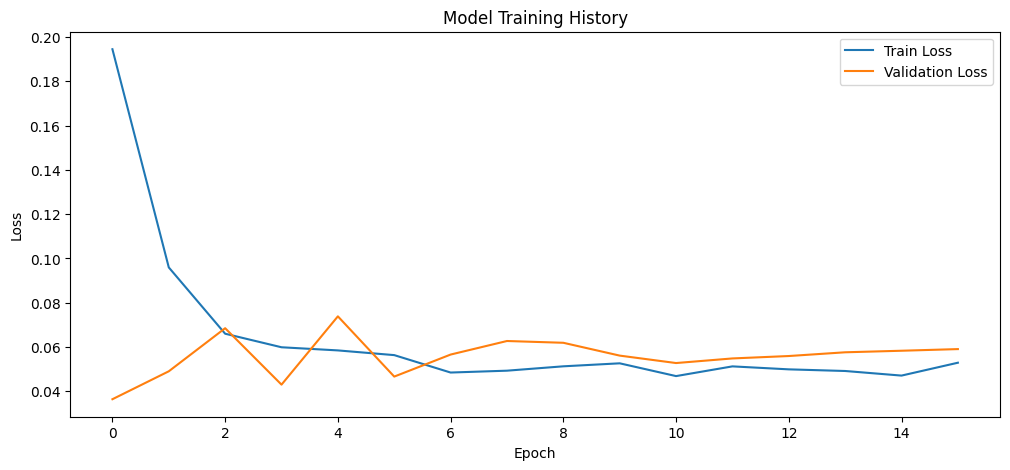

Model training and evaluation complete!


In [7]:
import numpy as np
import pandas as pd
import yfinance as yf
import datetime as dt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt

# Settings
N_STEPS = 20
LOOKUP_STEPS = [1, 2, 3]  # Predict next 1, 2, and 3 days
STOCK = 'GOOGL'
TEST_SIZE = 0.2
UNITS = 128
DROPOUT = 0.3
BATCH_SIZE = 64
EPOCHS = 200
LEARNING_RATE = 0.001
MIN_DATA_LENGTH = 100  # Minimum data points required

# Date range (3 years back from today)
end_date = dt.datetime.now()
start_date = end_date - dt.timedelta(days=1104)

# Download data
try:
    df = yf.download(
        STOCK,
        start=start_date.strftime('%Y-%m-%d'),
        end=end_date.strftime('%Y-%m-%d'),
        interval='1d'
    )
    
    if df.empty:
        raise ValueError(f"No data found for {STOCK}")
    else:
        print(f"Successfully downloaded {len(df)} days of data for {STOCK}")
        
except Exception as e:
    print(f"Error downloading data: {e}")
    exit()

# Keep only the 'Close' column initially
df = df[['Close']].copy()

# Add technical indicators with safe window sizes
def add_technical_indicators_safe(df, min_length=MIN_DATA_LENGTH):
    df = df.copy()
    
    # Calculate window sizes based on available data
    available_data = len(df)
    rsi_window = min(14, available_data // 2)
    ma_window = min(20, available_data // 2)
    vol_window = min(10, available_data // 2)
    
    # Simple Moving Averages
    df['SMA_10'] = df['Close'].rolling(window=min(10, available_data)).mean()
    df['SMA_30'] = df['Close'].rolling(window=min(30, available_data)).mean()
    
    # Volatility
    df['Volatility'] = df['Close'].rolling(window=vol_window).std()
    
    # RSI with safe window size
    delta = df['Close'].diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=rsi_window).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=rsi_window).mean()
    rs = gain / loss
    df['RSI'] = 100 - (100 / (1 + rs))
    
    # MACD with safe periods
    exp12 = df['Close'].ewm(span=min(12, available_data), adjust=False).mean()
    exp26 = df['Close'].ewm(span=min(26, available_data), adjust=False).mean()
    df['MACD'] = exp12 - exp26
    df['Signal'] = df['MACD'].ewm(span=min(9, available_data), adjust=False).mean()
    
    # Bollinger Bands with safe window
    rolling_mean = df['Close'].rolling(window=ma_window).mean()
    rolling_std = df['Close'].rolling(window=ma_window).std()
    df['Upper_Band'] = rolling_mean + (2 * rolling_std)
    df['Lower_Band'] = rolling_mean - (2 * rolling_std)
    
    # Daily Returns
    df['Daily_Return'] = df['Close'].pct_change()
    
    # Drop rows with NA values only if we still have enough data
    initial_na_count = df.isna().sum().sum()
    df.dropna(inplace=True)
    
    if len(df) < min_length:
        raise ValueError(f"After processing, only {len(df)} rows remain. Need at least {min_length} rows.")
    
    print(f"Removed {initial_na_count} NA values. Final dataset has {len(df)} rows.")
    return df

try:
    df = add_technical_indicators_safe(df)
except ValueError as e:
    print(f"Error in processing data: {e}")
    exit()

# Scale the data
scaler = RobustScaler()
scaled_data = scaler.fit_transform(df)

# Prepare the dataset with sequences
def prepare_dataset(data, n_steps, lookup_steps):
    X, y = [], []
    max_step = max(lookup_steps)
    
    for i in range(n_steps, len(data) - max_step):
        X.append(data[i - n_steps:i])
        y.append([data[i + step, 0] for step in lookup_steps])  # Only predict Close price
    
    return np.array(X), np.array(y)

try:
    X, y = prepare_dataset(scaled_data, N_STEPS, LOOKUP_STEPS)
    if len(X) == 0:
        raise ValueError("Not enough data to create sequences with current parameters")
except ValueError as e:
    print(f"Error preparing dataset: {e}")
    print(f"Available data: {len(scaled_data)} points, Need: {N_STEPS + max(LOOKUP_STEPS)}")
    exit()

# Split into train/test sets (preserving temporal order)
split_idx = int(len(X) * (1 - TEST_SIZE))
X_train, X_test = X[:split_idx], X[split_idx:]
y_train, y_test = y[:split_idx], y[split_idx:]

# Create the LSTM model
def create_model(sequence_length, n_features):
    model = Sequential()
    
    model.add(LSTM(units=UNITS, 
                  input_shape=(sequence_length, n_features),
                  return_sequences=True,
                  dropout=DROPOUT,
                  recurrent_dropout=DROPOUT))
    
    model.add(LSTM(units=int(UNITS/2),
                  dropout=DROPOUT,
                  recurrent_dropout=DROPOUT))
    
    model.add(Dense(units=int(UNITS/4), activation='relu'))
    model.add(Dropout(DROPOUT))
    model.add(Dense(len(LOOKUP_STEPS), activation='linear'))
    
    model.compile(
        optimizer=Adam(learning_rate=LEARNING_RATE),
        loss='mean_squared_error',
        metrics=['mae']
    )
    return model

model = create_model(
    sequence_length=N_STEPS,
    n_features=df.shape[1]
)

# Callbacks
callbacks = [
    EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.00001)
]

# Train the model
history = model.fit(
    X_train, y_train,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=(X_test, y_test),
    callbacks=callbacks,
    verbose=1
)

# Evaluate the model
def evaluate_model(model, X_test, y_test, scaler, lookup_steps):
    y_pred = model.predict(X_test)
    
    # Inverse transform the predictions
    y_test_orig = np.zeros((len(y_test), df.shape[1]))
    y_pred_orig = np.zeros((len(y_pred), df.shape[1]))
    
    results = {}
    for i, step in enumerate(lookup_steps):
        y_test_orig[:, 0] = y_test[:, i]
        y_pred_orig[:, 0] = y_pred[:, i]
        
        y_test_inv = scaler.inverse_transform(y_test_orig)[:, 0]
        y_pred_inv = scaler.inverse_transform(y_pred_orig)[:, 0]
        
        mae = mean_absolute_error(y_test_inv, y_pred_inv)
        rmse = np.sqrt(mean_squared_error(y_test_inv, y_pred_inv))
        r2 = r2_score(y_test_inv, y_pred_inv)
        
        results[f'{step}_day'] = {
            'MAE': mae,
            'RMSE': rmse,
            'R2': r2
        }
        
        print(f"\nMetrics for {step}-day prediction:")
        print(f"MAE: {mae:.4f}")
        print(f"RMSE: {rmse:.4f}")
        print(f"R2 Score: {r2:.4f}")
    
    return results

results = evaluate_model(model, X_test, y_test, scaler, LOOKUP_STEPS)

# Plot training history
plt.figure(figsize=(12, 5))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Training History')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

print("Model training and evaluation complete!")

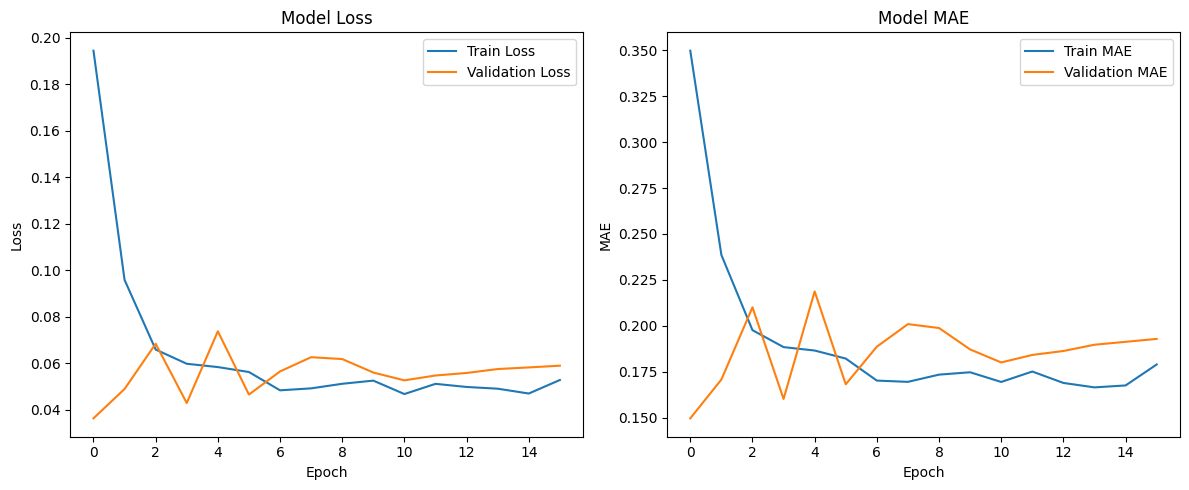

NameError: name 'y_test_orig' is not defined

In [9]:
def plot_history(history):
    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(history.history['mae'], label='Train MAE')
    plt.plot(history.history['val_mae'], label='Validation MAE')
    plt.title('Model MAE')
    plt.ylabel('MAE')
    plt.xlabel('Epoch')
    plt.legend()
    
    plt.tight_layout()
    plt.show()

plot_history(history)

# Plot predictions vs actual for each horizon
def plot_predictions(y_test_orig, y_pred_orig, lookup_steps):
    plt.figure(figsize=(15, 3*len(lookup_steps)))
    
    for i, step in enumerate(lookup_steps):
        plt.subplot(len(lookup_steps), 1, i+1)
        plt.plot(y_test_orig[i], label='Actual')
        plt.plot(y_pred_orig[i], label='Predicted')
        plt.title(f'{step}-Day Prediction')
        plt.xlabel('Time')
        plt.ylabel('Price')
        plt.legend()
    
    plt.tight_layout()
    plt.show()

plot_predictions(y_test_orig, y_pred_orig, LOOKUP_STEPS)

# Market stress detection function
def detect_market_stress(df, window=10, threshold=2):
    """
    Detect periods of market stress based on volatility and price drops
    
    Parameters:
    - df: DataFrame with price data
    - window: lookback window for stress calculation
    - threshold: number of standard deviations to consider as stress
    
    Returns:
    - DataFrame with stress signals
    """
    df = df.copy()
    
    # Calculate rolling volatility
    df['Returns'] = df['Close'].pct_change()
    df['Volatility'] = df['Returns'].rolling(window).std()
    
    # Calculate z-score of volatility
    df['Volatility_Z'] = (df['Volatility'] - df['Volatility'].rolling(window).mean()) / df['Volatility'].rolling(window).std()
    
    # Calculate price drop severity
    df['Price_Drop'] = df['Close'].pct_change(window)
    df['Drop_Z'] = (df['Price_Drop'] - df['Price_Drop'].rolling(window).mean()) / df['Price_Drop'].rolling(window).std()
    
    # Combined stress signal
    df['Stress_Signal'] = (df['Volatility_Z'] > threshold) | (df['Drop_Z'] < -threshold)
    
    return df

# Apply stress detection
df_stress = detect_market_stress(df)

# Plot stress periods
plt.figure(figsize=(15, 6))
plt.plot(df_stress.index, df_stress['Close'], label='Price')
stress_periods = df_stress[df_stress['Stress_Signal']]
plt.scatter(stress_periods.index, stress_periods['Close'], color='red', label='Stress Period')
plt.title('Market Stress Detection')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step

Metrics for 1-day prediction:
MAE: 7.8024
RMSE: 9.8749
R2 Score: 0.5622

Metrics for 2-day prediction:
MAE: 7.7419
RMSE: 10.0851
R2 Score: 0.5435

Metrics for 3-day prediction:
MAE: 7.1185
RMSE: 8.8990
R2 Score: 0.6449


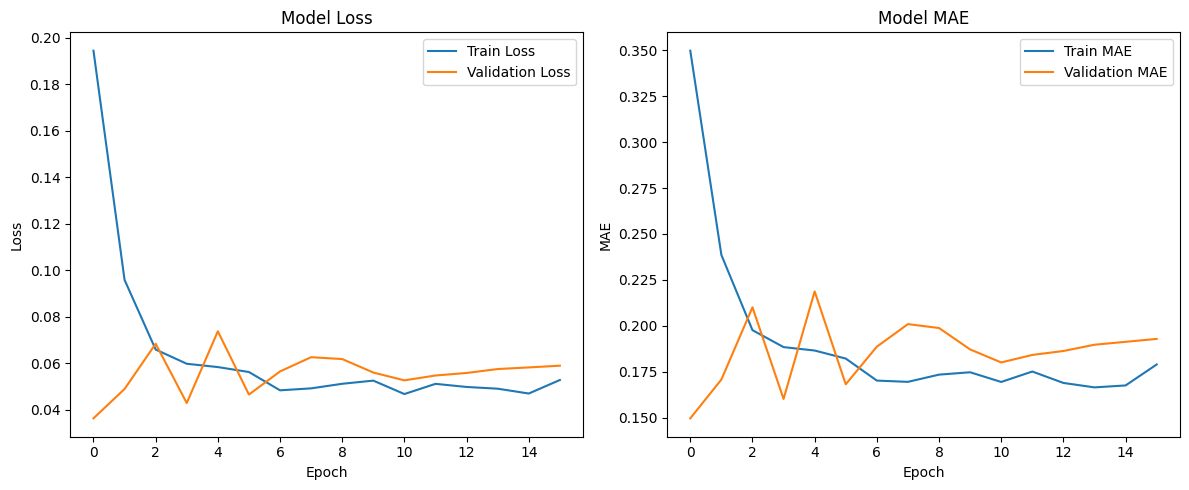

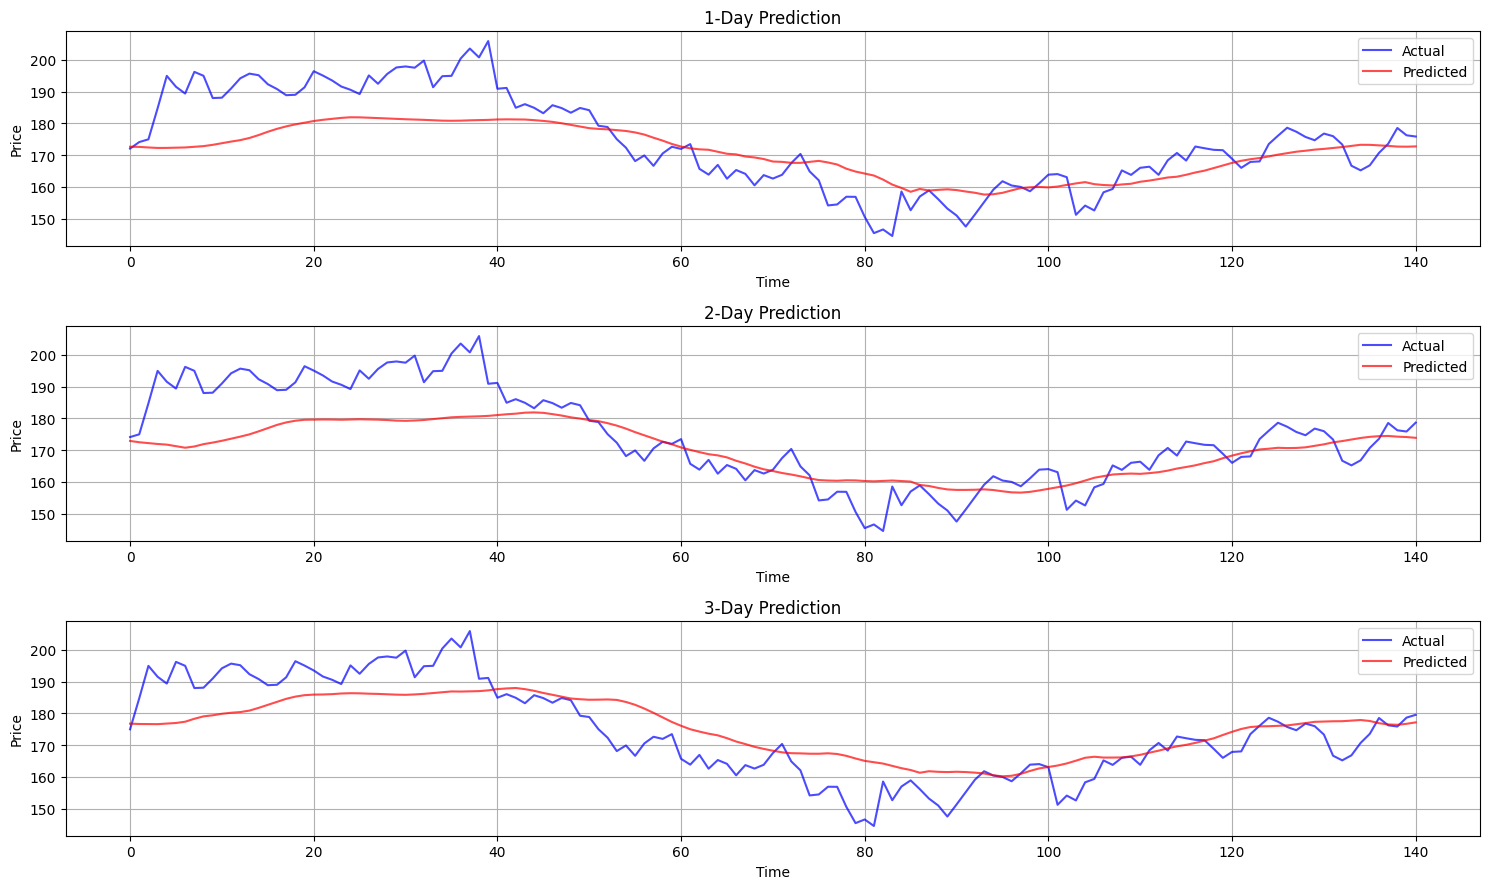

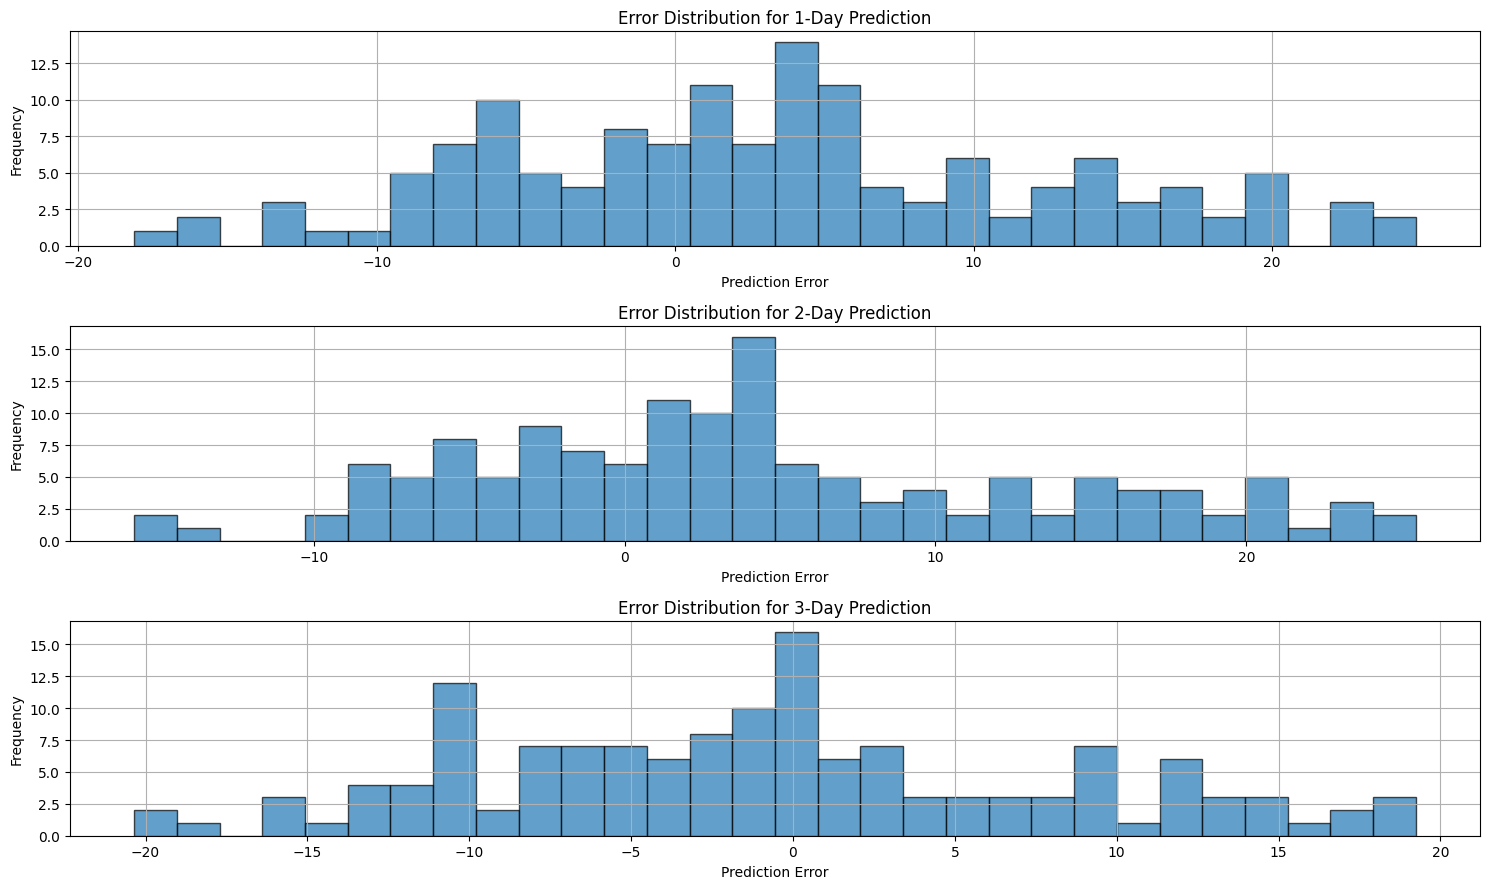

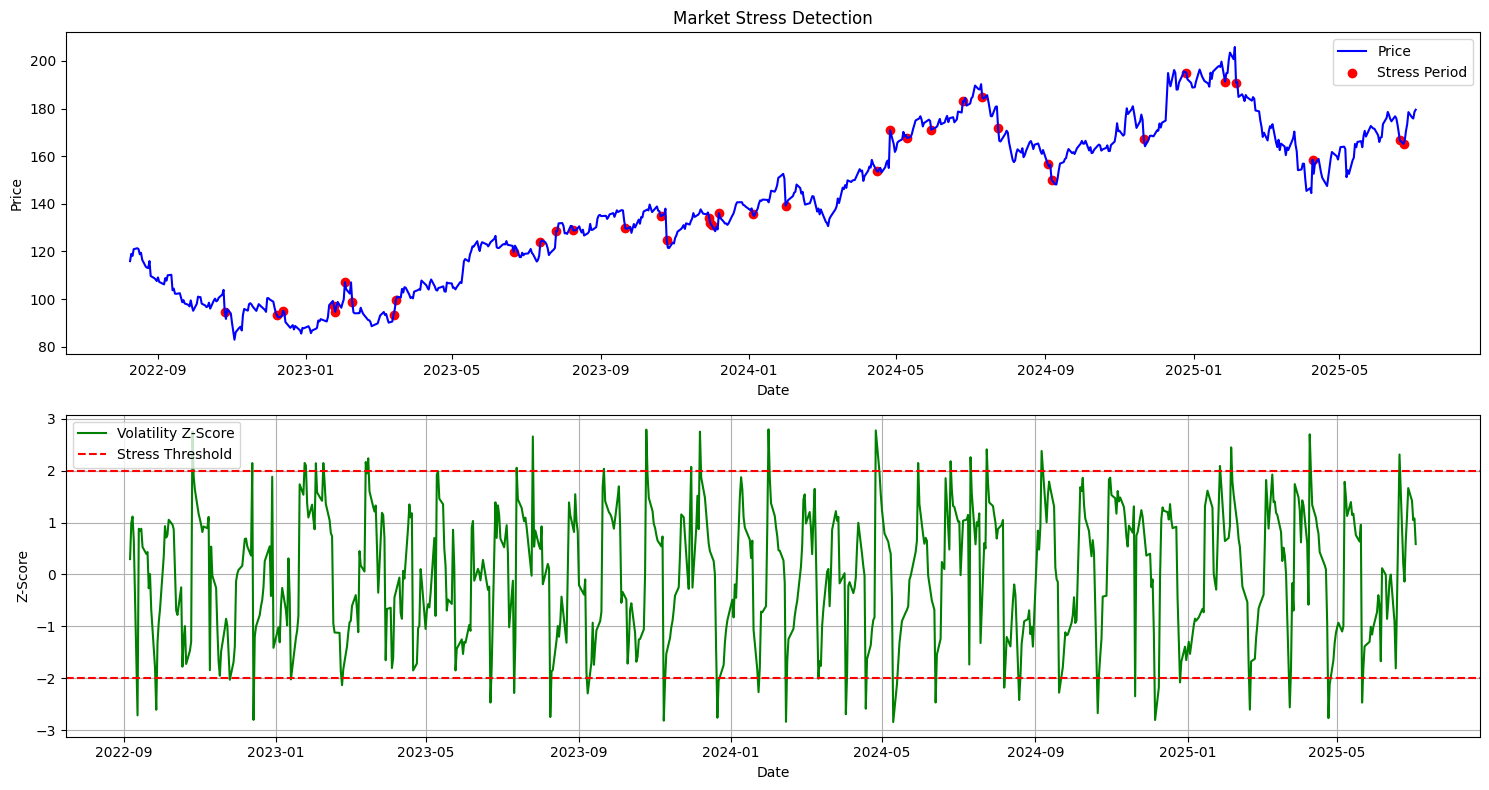

/var/folders/tb/6mz71wqd5zjdgj1f0dtrpk640000gn/T/ipykernel_14048/1299022180.py:182: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([normal_errors, stress_errors],
/var/folders/tb/6mz71wqd5zjdgj1f0dtrpk640000gn/T/ipykernel_14048/1299022180.py:182: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([normal_errors, stress_errors],
/var/folders/tb/6mz71wqd5zjdgj1f0dtrpk640000gn/T/ipykernel_14048/1299022180.py:182: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([normal_errors, stress_errors],


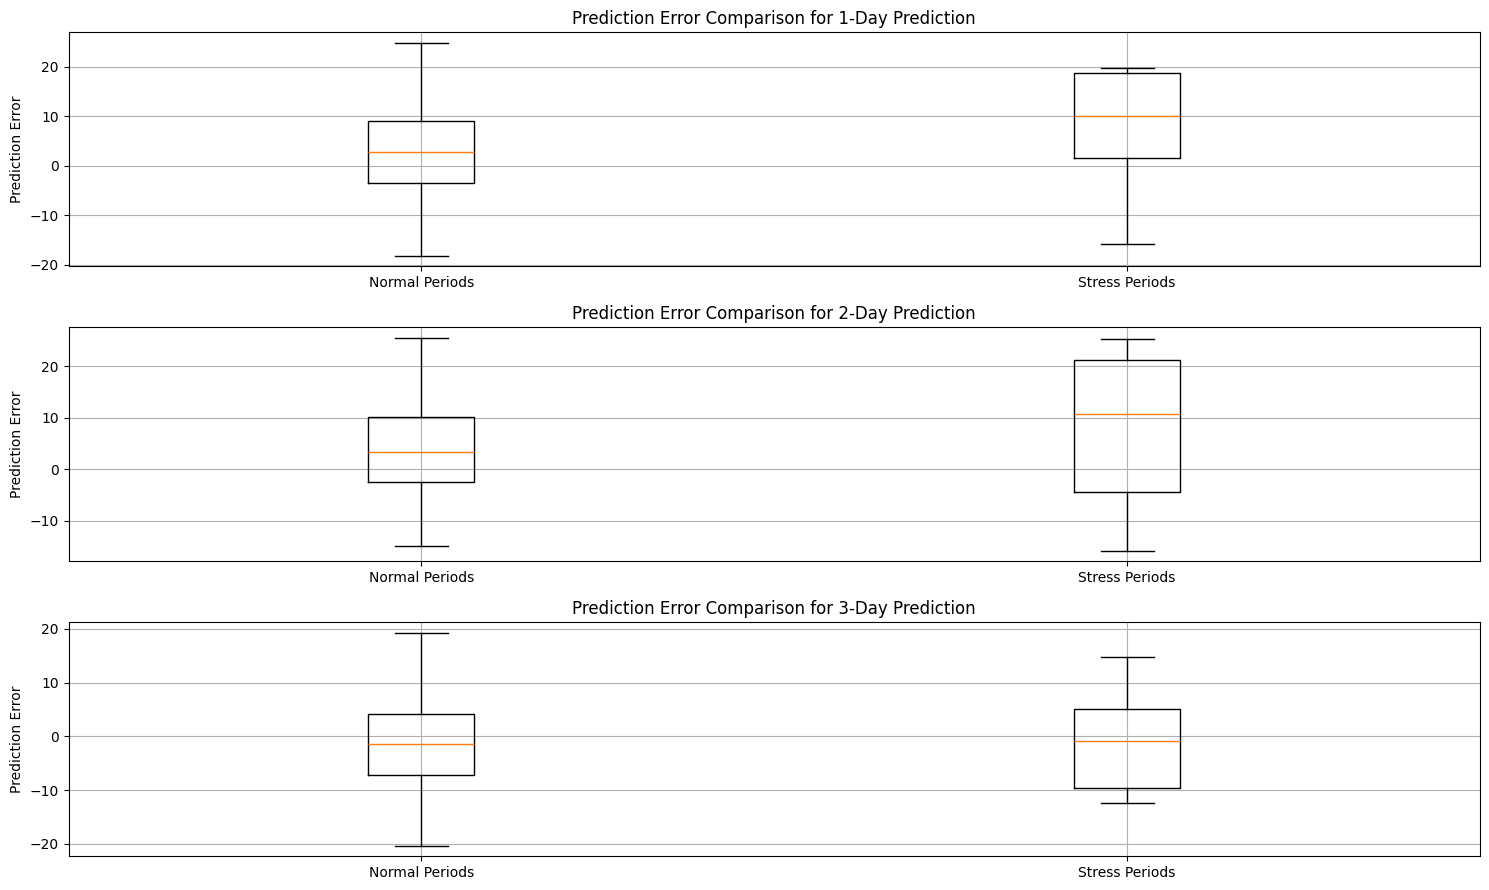

All performance analysis complete!


In [11]:
# (Previous imports and settings remain the same)

# ... [Previous code remains unchanged until after the evaluate_model function] ...
import numpy as np
import pandas as pd
import yfinance as yf
import datetime as dt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt

# Settings
N_STEPS = 20
LOOKUP_STEPS = [1, 2, 3]  # Predict next 1, 2, and 3 days
STOCK = 'GOOGL'
TEST_SIZE = 0.2
UNITS = 128
DROPOUT = 0.3
BATCH_SIZE = 64
EPOCHS = 200
LEARNING_RATE = 0.001
MIN_DATA_LENGTH = 100  # Minimum data points required

# Date range (3 years back from today)
end_date = dt.datetime.now()
start_date = end_date - dt.timedelta(days=1104)

# Download data
try:
    df = yf.download(
        STOCK,
        start=start_date.strftime('%Y-%m-%d'),
        end=end_date.strftime('%Y-%m-%d'),
        interval='1d'
    )
    
    if df.empty:
        raise ValueError(f"No data found for {STOCK}")
    else:
        print(f"Successfully downloaded {len(df)} days of data for {STOCK}")
        
except Exception as e:
    print(f"Error downloading data: {e}")
    exit()

# Keep only the 'Close' column initially
df = df[['Close']].copy()

# Add technical indicators with safe window sizes
def add_technical_indicators_safe(df, min_length=MIN_DATA_LENGTH):
    df = df.copy()
    
    # Calculate window sizes based on available data
    available_data = len(df)
    rsi_window = min(14, available_data // 2)
    ma_window = min(20, available_data // 2)
    vol_window = min(10, available_data // 2)
    
    # Simple Moving Averages
    df['SMA_10'] = df['Close'].rolling(window=min(10, available_data)).mean()
    df['SMA_30'] = df['Close'].rolling(window=min(30, available_data)).mean()
    
    # Volatility
    df['Volatility'] = df['Close'].rolling(window=vol_window).std()
    
    # RSI with safe window size
    delta = df['Close'].diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=rsi_window).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=rsi_window).mean()
    rs = gain / loss
    df['RSI'] = 100 - (100 / (1 + rs))
    
    # MACD with safe periods
    exp12 = df['Close'].ewm(span=min(12, available_data), adjust=False).mean()
    exp26 = df['Close'].ewm(span=min(26, available_data), adjust=False).mean()
    df['MACD'] = exp12 - exp26
    df['Signal'] = df['MACD'].ewm(span=min(9, available_data), adjust=False).mean()
    
    # Bollinger Bands with safe window
    rolling_mean = df['Close'].rolling(window=ma_window).mean()
    rolling_std = df['Close'].rolling(window=ma_window).std()
    df['Upper_Band'] = rolling_mean + (2 * rolling_std)
    df['Lower_Band'] = rolling_mean - (2 * rolling_std)
    
    # Daily Returns
    df['Daily_Return'] = df['Close'].pct_change()
    
    # Drop rows with NA values only if we still have enough data
    initial_na_count = df.isna().sum().sum()
    df.dropna(inplace=True)
    
    if len(df) < min_length:
        raise ValueError(f"After processing, only {len(df)} rows remain. Need at least {min_length} rows.")
    
    print(f"Removed {initial_na_count} NA values. Final dataset has {len(df)} rows.")
    return df

try:
    df = add_technical_indicators_safe(df)
except ValueError as e:
    print(f"Error in processing data: {e}")
    exit()

# Scale the data
scaler = RobustScaler()
scaled_data = scaler.fit_transform(df)

# Prepare the dataset with sequences
def prepare_dataset(data, n_steps, lookup_steps):
    X, y = [], []
    max_step = max(lookup_steps)
    
    for i in range(n_steps, len(data) - max_step):
        X.append(data[i - n_steps:i])
        y.append([data[i + step, 0] for step in lookup_steps])  # Only predict Close price
    
    return np.array(X), np.array(y)

try:
    X, y = prepare_dataset(scaled_data, N_STEPS, LOOKUP_STEPS)
    if len(X) == 0:
        raise ValueError("Not enough data to create sequences with current parameters")
except ValueError as e:
    print(f"Error preparing dataset: {e}")
    print(f"Available data: {len(scaled_data)} points, Need: {N_STEPS + max(LOOKUP_STEPS)}")
    exit()

# Split into train/test sets (preserving temporal order)
split_idx = int(len(X) * (1 - TEST_SIZE))
X_train, X_test = X[:split_idx], X[split_idx:]
y_train, y_test = y[:split_idx], y[split_idx:]

# Create the LSTM model
def create_model(sequence_length, n_features):
    model = Sequential()
    
    model.add(LSTM(units=UNITS, 
                  input_shape=(sequence_length, n_features),
                  return_sequences=True,
                  dropout=DROPOUT,
                  recurrent_dropout=DROPOUT))
    
    model.add(LSTM(units=int(UNITS/2),
                  dropout=DROPOUT,
                  recurrent_dropout=DROPOUT))
    
    model.add(Dense(units=int(UNITS/4), activation='relu'))
    model.add(Dropout(DROPOUT))
    model.add(Dense(len(LOOKUP_STEPS), activation='linear'))
    
    model.compile(
        optimizer=Adam(learning_rate=LEARNING_RATE),
        loss='mean_squared_error',
        metrics=['mae']
    )
    return model

model = create_model(
    sequence_length=N_STEPS,
    n_features=df.shape[1]
)

# Callbacks
callbacks = [
    EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.00001)
]

# Train the model
history = model.fit(
    X_train, y_train,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=(X_test, y_test),
    callbacks=callbacks,
    verbose=1
)
def evaluate_model(model, X_test, y_test, scaler, lookup_steps):
    y_pred = model.predict(X_test)
    
    # Prepare arrays for inverse transform
    dummy_array = np.zeros((len(y_test), df.shape[1]))
    
    # Store inverse transformed values for each prediction horizon
    y_test_orig = []
    y_pred_orig = []
    
    for i in range(len(lookup_steps)):
        # Create dummy array with just the close price predictions
        dummy_array[:, 0] = y_test[:, i]
        y_test_inv = scaler.inverse_transform(dummy_array)[:, 0]
        
        dummy_array[:, 0] = y_pred[:, i]
        y_pred_inv = scaler.inverse_transform(dummy_array)[:, 0]
        
        y_test_orig.append(y_test_inv)
        y_pred_orig.append(y_pred_inv)
        
        # Calculate metrics
        mae = mean_absolute_error(y_test_inv, y_pred_inv)
        rmse = np.sqrt(mean_squared_error(y_test_inv, y_pred_inv))
        r2 = r2_score(y_test_inv, y_pred_inv)
        
        print(f"\nMetrics for {lookup_steps[i]}-day prediction:")
        print(f"MAE: {mae:.4f}")
        print(f"RMSE: {rmse:.4f}")
        print(f"R2 Score: {r2:.4f}")
    
    return y_test_orig, y_pred_orig

# Get the inverse transformed predictions
y_test_orig, y_pred_orig = evaluate_model(model, X_test, y_test, scaler, LOOKUP_STEPS)

# 1. Plot training history
def plot_training_history(history):
    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(history.history['mae'], label='Train MAE')
    plt.plot(history.history['val_mae'], label='Validation MAE')
    plt.title('Model MAE')
    plt.ylabel('MAE')
    plt.xlabel('Epoch')
    plt.legend()
    
    plt.tight_layout()
    plt.show()

plot_training_history(history)

# 2. Plot predictions vs actual for each horizon
def plot_predictions(y_test_orig, y_pred_orig, lookup_steps):
    plt.figure(figsize=(15, 3*len(lookup_steps)))
    
    for i, step in enumerate(lookup_steps):
        plt.subplot(len(lookup_steps), 1, i+1)
        plt.plot(y_test_orig[i], label='Actual', color='blue', alpha=0.7)
        plt.plot(y_pred_orig[i], label='Predicted', color='red', alpha=0.7)
        plt.title(f'{step}-Day Prediction')
        plt.xlabel('Time')
        plt.ylabel('Price')
        plt.legend()
        plt.grid(True)
    
    plt.tight_layout()
    plt.show()

plot_predictions(y_test_orig, y_pred_orig, LOOKUP_STEPS)

# 3. Plot error distribution
def plot_error_distribution(y_test_orig, y_pred_orig, lookup_steps):
    plt.figure(figsize=(15, 3*len(lookup_steps)))
    
    for i, step in enumerate(lookup_steps):
        errors = y_test_orig[i] - y_pred_orig[i]
        plt.subplot(len(lookup_steps), 1, i+1)
        plt.hist(errors, bins=30, edgecolor='black', alpha=0.7)
        plt.title(f'Error Distribution for {step}-Day Prediction')
        plt.xlabel('Prediction Error')
        plt.ylabel('Frequency')
        plt.grid(True)
    
    plt.tight_layout()
    plt.show()

plot_error_distribution(y_test_orig, y_pred_orig, LOOKUP_STEPS)

# 4. Market stress detection and visualization
def detect_market_stress(df, window=10, threshold=2):
    """
    Detect periods of market stress based on volatility and price drops
    
    Parameters:
    - df: DataFrame with price data
    - window: lookback window for stress calculation
    - threshold: number of standard deviations to consider as stress
    
    Returns:
    - DataFrame with stress signals
    """
    df = df.copy()
    
    # Calculate rolling volatility
    df['Returns'] = df['Close'].pct_change()
    df['Volatility'] = df['Returns'].rolling(window).std()
    
    # Calculate z-score of volatility
    df['Volatility_Z'] = (df['Volatility'] - df['Volatility'].rolling(window).mean()) / df['Volatility'].rolling(window).std()
    
    # Calculate price drop severity
    df['Price_Drop'] = df['Close'].pct_change(window)
    df['Drop_Z'] = (df['Price_Drop'] - df['Price_Drop'].rolling(window).mean()) / df['Price_Drop'].rolling(window).std()
    
    # Combined stress signal
    df['Stress_Signal'] = (df['Volatility_Z'] > threshold) | (df['Drop_Z'] < -threshold)
    
    return df

# Apply stress detection
df_stress = detect_market_stress(df)

# Plot stress periods
def plot_stress_periods(df_stress):
    plt.figure(figsize=(15, 8))
    
    # Plot price and stress signals
    plt.subplot(2, 1, 1)
    plt.plot(df_stress.index, df_stress['Close'], label='Price', color='blue')
    stress_periods = df_stress[df_stress['Stress_Signal']]
    plt.scatter(stress_periods.index, stress_periods['Close'], color='red', label='Stress Period')
    plt.title('Market Stress Detection')
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.legend()
    
    # Plot volatility and threshold
    plt.subplot(2, 1, 2)
    plt.plot(df_stress.index, df_stress['Volatility_Z'], label='Volatility Z-Score', color='green')
    plt.axhline(y=2, color='red', linestyle='--', label='Stress Threshold')
    plt.axhline(y=-2, color='red', linestyle='--')
    plt.xlabel('Date')
    plt.ylabel('Z-Score')
    plt.legend()
    plt.grid(True)
    
    plt.tight_layout()
    plt.show()

plot_stress_periods(df_stress)

# 5. Plot prediction errors during stress vs normal periods
def plot_stress_errors(df_stress, y_test_orig, y_pred_orig, lookup_steps):
    # Align stress signals with test periods
    test_dates = df_stress.index[-len(y_test_orig[0]):]  # Use dates for the test period
    test_stress = df_stress.loc[test_dates, 'Stress_Signal']
    
    plt.figure(figsize=(15, 3*len(lookup_steps)))
    
    for i, step in enumerate(lookup_steps):
        errors = y_test_orig[i] - y_pred_orig[i]
        
        # Split errors into stress and normal periods
        stress_errors = errors[test_stress]
        normal_errors = errors[~test_stress]
        
        plt.subplot(len(lookup_steps), 1, i+1)
        plt.boxplot([normal_errors, stress_errors], 
                   labels=['Normal Periods', 'Stress Periods'])
        plt.title(f'Prediction Error Comparison for {step}-Day Prediction')
        plt.ylabel('Prediction Error')
        plt.grid(True)
    
    plt.tight_layout()
    plt.show()

plot_stress_errors(df_stress, y_test_orig, y_pred_orig, LOOKUP_STEPS)

print("All performance analysis complete!")

In [15]:
df_backup=df.copy()

/var/folders/tb/6mz71wqd5zjdgj1f0dtrpk640000gn/T/ipykernel_14048/3055867069.py:37: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df_raw = yf.download(
[*********************100%***********************]  1 of 1 completed

Successfully downloaded 1717 days of data for GOOGL
--- Starting Bayesian Optimization ---
  0%|                                    | 0/50 [00:00<?, ?trial/s, best loss=?]


/opt/anaconda3/envs/myenv/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)



Trial completed: RMSE = 22.7286, MAE = 20.4408 with params: {'batch_size': 64.0, 'dropout': 0.3553638924245647, 'learning_rate': 0.0017455833804843229, 'macd_exp1_window': 15.0, 'macd_exp2_window': 34.0, 'macd_signal_window': 6.0, 'n_steps': 45.0, 'rsi_window': 16.0, 'sma_10_window': 6.0, 'sma_30_window': 20.0, 'units': 160.0, 'vol_window': 7.0}
  2%|▏       | 1/50 [01:25<1:09:43, 85.38s/trial, best loss: 22.728556562798424]

/opt/anaconda3/envs/myenv/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)



Trial completed: RMSE = 15.5799, MAE = 13.6344 with params: {'batch_size': 64.0, 'dropout': 0.14717727713257944, 'learning_rate': 0.0011006249416740392, 'macd_exp1_window': 15.0, 'macd_exp2_window': 35.0, 'macd_signal_window': 6.0, 'n_steps': 25.0, 'rsi_window': 8.0, 'sma_10_window': 18.0, 'sma_30_window': 40.0, 'units': 256.0, 'vol_window': 19.0}
  4%|▎       | 2/50 [02:39<1:02:47, 78.49s/trial, best loss: 15.579913011436963]

/opt/anaconda3/envs/myenv/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)



Trial completed: RMSE = 27.5089, MAE = 25.2187 with params: {'batch_size': 96.0, 'dropout': 0.46269754270907415, 'learning_rate': 0.003131948998561225, 'macd_exp1_window': 13.0, 'macd_exp2_window': 33.0, 'macd_signal_window': 5.0, 'n_steps': 30.0, 'rsi_window': 7.0, 'sma_10_window': 11.0, 'sma_30_window': 55.0, 'units': 96.0, 'vol_window': 9.0}
  6%|▌         | 3/50 [03:04<42:26, 54.18s/trial, best loss: 15.579913011436963]

/opt/anaconda3/envs/myenv/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)



Trial completed: RMSE = 23.2054, MAE = 21.0875 with params: {'batch_size': 32.0, 'dropout': 0.3227573379449498, 'learning_rate': 0.0025106589425452916, 'macd_exp1_window': 12.0, 'macd_exp2_window': 22.0, 'macd_signal_window': 12.0, 'n_steps': 15.0, 'rsi_window': 28.0, 'sma_10_window': 11.0, 'sma_30_window': 25.0, 'units': 64.0, 'vol_window': 9.0}
  8%|▊         | 4/50 [03:24<31:20, 40.88s/trial, best loss: 15.579913011436963]

/opt/anaconda3/envs/myenv/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)



Trial completed: RMSE = 17.4857, MAE = 14.4798 with params: {'batch_size': 128.0, 'dropout': 0.4816752964137544, 'learning_rate': 0.0016681927837005046, 'macd_exp1_window': 8.0, 'macd_exp2_window': 32.0, 'macd_signal_window': 8.0, 'n_steps': 45.0, 'rsi_window': 11.0, 'sma_10_window': 10.0, 'sma_30_window': 45.0, 'units': 128.0, 'vol_window': 18.0}
 10%|█         | 5/50 [03:59<28:51, 38.49s/trial, best loss: 15.579913011436963]

/opt/anaconda3/envs/myenv/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)



Trial completed: RMSE = 27.9854, MAE = 25.7830 with params: {'batch_size': 96.0, 'dropout': 0.36146410150803276, 'learning_rate': 0.00015503529381626408, 'macd_exp1_window': 10.0, 'macd_exp2_window': 23.0, 'macd_signal_window': 9.0, 'n_steps': 15.0, 'rsi_window': 13.0, 'sma_10_window': 19.0, 'sma_30_window': 35.0, 'units': 96.0, 'vol_window': 12.0}
 12%|█▏        | 6/50 [04:17<23:17, 31.76s/trial, best loss: 15.579913011436963]

/opt/anaconda3/envs/myenv/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)



Trial completed: RMSE = 15.2446, MAE = 12.9687 with params: {'batch_size': 128.0, 'dropout': 0.4344193429451434, 'learning_rate': 0.00044234513296422125, 'macd_exp1_window': 10.0, 'macd_exp2_window': 31.0, 'macd_signal_window': 10.0, 'n_steps': 45.0, 'rsi_window': 20.0, 'sma_10_window': 10.0, 'sma_30_window': 45.0, 'units': 224.0, 'vol_window': 17.0}
 14%|█▍        | 7/50 [05:33<33:01, 46.09s/trial, best loss: 15.244621024555732]

/opt/anaconda3/envs/myenv/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)



Trial completed: RMSE = 33.8703, MAE = 31.9345 with params: {'batch_size': 96.0, 'dropout': 0.44696558710162426, 'learning_rate': 0.005016379852533945, 'macd_exp1_window': 13.0, 'macd_exp2_window': 28.0, 'macd_signal_window': 6.0, 'n_steps': 15.0, 'rsi_window': 18.0, 'sma_10_window': 16.0, 'sma_30_window': 50.0, 'units': 64.0, 'vol_window': 10.0}
 16%|█▌        | 8/50 [05:45<24:40, 35.26s/trial, best loss: 15.244621024555732]

/opt/anaconda3/envs/myenv/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)



Trial completed: RMSE = 24.6598, MAE = 22.6697 with params: {'batch_size': 64.0, 'dropout': 0.351978753091739, 'learning_rate': 0.000311496753341036, 'macd_exp1_window': 14.0, 'macd_exp2_window': 25.0, 'macd_signal_window': 9.0, 'n_steps': 20.0, 'rsi_window': 8.0, 'sma_10_window': 18.0, 'sma_30_window': 55.0, 'units': 96.0, 'vol_window': 18.0}
 18%|█▊        | 9/50 [06:03<20:24, 29.86s/trial, best loss: 15.244621024555732]

/opt/anaconda3/envs/myenv/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)



Trial completed: RMSE = 26.4739, MAE = 24.4829 with params: {'batch_size': 64.0, 'dropout': 0.4457322419061678, 'learning_rate': 0.0008861243674540949, 'macd_exp1_window': 9.0, 'macd_exp2_window': 22.0, 'macd_signal_window': 8.0, 'n_steps': 15.0, 'rsi_window': 27.0, 'sma_10_window': 7.0, 'sma_30_window': 35.0, 'units': 96.0, 'vol_window': 12.0}
 20%|█▊       | 10/50 [06:20<17:21, 26.03s/trial, best loss: 15.244621024555732]

/opt/anaconda3/envs/myenv/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)



Trial completed: RMSE = 7.0357, MAE = 5.5191 with params: {'batch_size': 128.0, 'dropout': 0.22269956021655202, 'learning_rate': 0.0008222624277136362, 'macd_exp1_window': 11.0, 'macd_exp2_window': 32.0, 'macd_signal_window': 9.0, 'n_steps': 15.0, 'rsi_window': 10.0, 'sma_10_window': 11.0, 'sma_30_window': 40.0, 'units': 192.0, 'vol_window': 6.0}
 22%|██▏       | 11/50 [06:46<16:51, 25.95s/trial, best loss: 7.035677064353757]

/opt/anaconda3/envs/myenv/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)



Trial completed: RMSE = 19.0913, MAE = 17.1984 with params: {'batch_size': 64.0, 'dropout': 0.19125792793039956, 'learning_rate': 0.0002458483255588342, 'macd_exp1_window': 12.0, 'macd_exp2_window': 31.0, 'macd_signal_window': 12.0, 'n_steps': 35.0, 'rsi_window': 24.0, 'sma_10_window': 6.0, 'sma_30_window': 30.0, 'units': 192.0, 'vol_window': 18.0}
 24%|██▍       | 12/50 [07:48<23:18, 36.80s/trial, best loss: 7.035677064353757]

/opt/anaconda3/envs/myenv/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)



Trial completed: RMSE = 27.6030, MAE = 25.3611 with params: {'batch_size': 64.0, 'dropout': 0.23072916949672972, 'learning_rate': 0.0014247202131823726, 'macd_exp1_window': 12.0, 'macd_exp2_window': 24.0, 'macd_signal_window': 10.0, 'n_steps': 20.0, 'rsi_window': 28.0, 'sma_10_window': 9.0, 'sma_30_window': 25.0, 'units': 64.0, 'vol_window': 16.0}
 26%|██▌       | 13/50 [08:06<19:14, 31.21s/trial, best loss: 7.035677064353757]

/opt/anaconda3/envs/myenv/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)



Trial completed: RMSE = 23.8686, MAE = 22.0351 with params: {'batch_size': 64.0, 'dropout': 0.2545795711266659, 'learning_rate': 0.0030462769337850975, 'macd_exp1_window': 11.0, 'macd_exp2_window': 26.0, 'macd_signal_window': 6.0, 'n_steps': 20.0, 'rsi_window': 22.0, 'sma_10_window': 13.0, 'sma_30_window': 60.0, 'units': 192.0, 'vol_window': 15.0}
 28%|██▊       | 14/50 [08:50<20:58, 34.95s/trial, best loss: 7.035677064353757]

/opt/anaconda3/envs/myenv/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)



Trial completed: RMSE = 23.4188, MAE = 21.5526 with params: {'batch_size': 64.0, 'dropout': 0.39064344442788324, 'learning_rate': 0.004301064168378421, 'macd_exp1_window': 15.0, 'macd_exp2_window': 25.0, 'macd_signal_window': 11.0, 'n_steps': 25.0, 'rsi_window': 25.0, 'sma_10_window': 9.0, 'sma_30_window': 40.0, 'units': 192.0, 'vol_window': 10.0}
 30%|███       | 15/50 [09:33<21:47, 37.36s/trial, best loss: 7.035677064353757]

/opt/anaconda3/envs/myenv/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)



Trial completed: RMSE = 18.0583, MAE = 16.2140 with params: {'batch_size': 128.0, 'dropout': 0.3121297327658502, 'learning_rate': 0.0028329400189346142, 'macd_exp1_window': 11.0, 'macd_exp2_window': 30.0, 'macd_signal_window': 6.0, 'n_steps': 15.0, 'rsi_window': 20.0, 'sma_10_window': 16.0, 'sma_30_window': 35.0, 'units': 256.0, 'vol_window': 5.0}
 32%|███▏      | 16/50 [10:12<21:31, 38.00s/trial, best loss: 7.035677064353757]

/opt/anaconda3/envs/myenv/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)



Trial completed: RMSE = 24.4404, MAE = 22.8499 with params: {'batch_size': 64.0, 'dropout': 0.3268036882878309, 'learning_rate': 0.0006502885958233713, 'macd_exp1_window': 13.0, 'macd_exp2_window': 23.0, 'macd_signal_window': 6.0, 'n_steps': 35.0, 'rsi_window': 10.0, 'sma_10_window': 10.0, 'sma_30_window': 45.0, 'units': 96.0, 'vol_window': 6.0}
 34%|███▍      | 17/50 [10:39<19:00, 34.56s/trial, best loss: 7.035677064353757]

/opt/anaconda3/envs/myenv/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)



Trial completed: RMSE = 20.9600, MAE = 18.9379 with params: {'batch_size': 96.0, 'dropout': 0.3372559781820672, 'learning_rate': 0.0014054950914384504, 'macd_exp1_window': 14.0, 'macd_exp2_window': 28.0, 'macd_signal_window': 11.0, 'n_steps': 10.0, 'rsi_window': 22.0, 'sma_10_window': 14.0, 'sma_30_window': 40.0, 'units': 128.0, 'vol_window': 17.0}
 36%|███▌      | 18/50 [10:55<15:33, 29.16s/trial, best loss: 7.035677064353757]

/opt/anaconda3/envs/myenv/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)



Trial completed: RMSE = 16.3678, MAE = 14.4737 with params: {'batch_size': 96.0, 'dropout': 0.3238693421637895, 'learning_rate': 0.00016209145328913025, 'macd_exp1_window': 16.0, 'macd_exp2_window': 34.0, 'macd_signal_window': 8.0, 'n_steps': 30.0, 'rsi_window': 10.0, 'sma_10_window': 7.0, 'sma_30_window': 40.0, 'units': 160.0, 'vol_window': 18.0}
 38%|███▊      | 19/50 [11:42<17:44, 34.35s/trial, best loss: 7.035677064353757]

/opt/anaconda3/envs/myenv/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)



Trial completed: RMSE = 32.2901, MAE = 31.0716 with params: {'batch_size': 96.0, 'dropout': 0.48728497579752184, 'learning_rate': 0.000105502136872397, 'macd_exp1_window': 10.0, 'macd_exp2_window': 28.0, 'macd_signal_window': 6.0, 'n_steps': 30.0, 'rsi_window': 25.0, 'sma_10_window': 6.0, 'sma_30_window': 35.0, 'units': 128.0, 'vol_window': 14.0}
 40%|████      | 20/50 [12:30<19:12, 38.43s/trial, best loss: 7.035677064353757]

/opt/anaconda3/envs/myenv/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)



Trial completed: RMSE = 18.0666, MAE = 16.0152 with params: {'batch_size': 128.0, 'dropout': 0.1202190124744077, 'learning_rate': 0.0004914045200534915, 'macd_exp1_window': 8.0, 'macd_exp2_window': 30.0, 'macd_signal_window': 10.0, 'n_steps': 50.0, 'rsi_window': 15.0, 'sma_10_window': 14.0, 'sma_30_window': 45.0, 'units': 224.0, 'vol_window': 14.0}
 42%|████▏     | 21/50 [14:02<26:24, 54.64s/trial, best loss: 7.035677064353757]

/opt/anaconda3/envs/myenv/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)



Trial completed: RMSE = 16.4267, MAE = 14.5632 with params: {'batch_size': 128.0, 'dropout': 0.27189078805622663, 'learning_rate': 0.0004617096009332735, 'macd_exp1_window': 10.0, 'macd_exp2_window': 30.0, 'macd_signal_window': 10.0, 'n_steps': 40.0, 'rsi_window': 19.0, 'sma_10_window': 12.0, 'sma_30_window': 50.0, 'units': 224.0, 'vol_window': 20.0}
 44%|████▍     | 22/50 [15:11<27:28, 58.87s/trial, best loss: 7.035677064353757]

/opt/anaconda3/envs/myenv/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)



Trial completed: RMSE = 17.2717, MAE = 14.1310 with params: {'batch_size': 128.0, 'dropout': 0.40789722344085283, 'learning_rate': 0.0003095711209807041, 'macd_exp1_window': 9.0, 'macd_exp2_window': 32.0, 'macd_signal_window': 9.0, 'n_steps': 50.0, 'rsi_window': 15.0, 'sma_10_window': 8.0, 'sma_30_window': 45.0, 'units': 224.0, 'vol_window': 7.0}
 46%|████▌     | 23/50 [16:40<30:33, 67.89s/trial, best loss: 7.035677064353757]

/opt/anaconda3/envs/myenv/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)



Trial completed: RMSE = 17.9522, MAE = 14.1750 with params: {'batch_size': 128.0, 'dropout': 0.177854306775009, 'learning_rate': 0.007914773378563743, 'macd_exp1_window': 11.0, 'macd_exp2_window': 32.0, 'macd_signal_window': 11.0, 'n_steps': 40.0, 'rsi_window': 21.0, 'sma_10_window': 12.0, 'sma_30_window': 50.0, 'units': 224.0, 'vol_window': 13.0}
 48%|████▊     | 24/50 [17:51<29:52, 68.95s/trial, best loss: 7.035677064353757]

/opt/anaconda3/envs/myenv/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)



Trial completed: RMSE = 16.9976, MAE = 14.8855 with params: {'batch_size': 128.0, 'dropout': 0.22011099202628462, 'learning_rate': 0.0007253760009091666, 'macd_exp1_window': 9.0, 'macd_exp2_window': 20.0, 'macd_signal_window': 7.0, 'n_steps': 10.0, 'rsi_window': 17.0, 'sma_10_window': 15.0, 'sma_30_window': 30.0, 'units': 192.0, 'vol_window': 20.0}
 50%|█████     | 25/50 [18:14<23:01, 55.24s/trial, best loss: 7.035677064353757]

/opt/anaconda3/envs/myenv/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)



Trial completed: RMSE = 14.8749, MAE = 13.2473 with params: {'batch_size': 128.0, 'dropout': 0.2674948334987899, 'learning_rate': 0.0005068820782044749, 'macd_exp1_window': 11.0, 'macd_exp2_window': 29.0, 'macd_signal_window': 10.0, 'n_steps': 45.0, 'rsi_window': 13.0, 'sma_10_window': 9.0, 'sma_30_window': 55.0, 'units': 256.0, 'vol_window': 11.0}
 52%|█████▏    | 26/50 [19:40<25:47, 64.48s/trial, best loss: 7.035677064353757]

/opt/anaconda3/envs/myenv/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)



Trial completed: RMSE = 8.0444, MAE = 6.5146 with params: {'batch_size': 32.0, 'dropout': 0.2820504924662731, 'learning_rate': 0.0006469622116261474, 'macd_exp1_window': 11.0, 'macd_exp2_window': 27.0, 'macd_signal_window': 9.0, 'n_steps': 35.0, 'rsi_window': 13.0, 'sma_10_window': 8.0, 'sma_30_window': 55.0, 'units': 256.0, 'vol_window': 8.0}
 54%|█████▍    | 27/50 [22:15<35:06, 91.60s/trial, best loss: 7.035677064353757]

/opt/anaconda3/envs/myenv/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)



Trial completed: RMSE = 20.7125, MAE = 19.0584 with params: {'batch_size': 32.0, 'dropout': 0.1010226244440866, 'learning_rate': 0.0009026165397593665, 'macd_exp1_window': 11.0, 'macd_exp2_window': 26.0, 'macd_signal_window': 7.0, 'n_steps': 35.0, 'rsi_window': 12.0, 'sma_10_window': 5.0, 'sma_30_window': 55.0, 'units': 160.0, 'vol_window': 5.0}
 56%|█████▌    | 28/50 [23:26<31:17, 85.32s/trial, best loss: 7.035677064353757]

/opt/anaconda3/envs/myenv/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)



Trial completed: RMSE = 15.8776, MAE = 13.7547 with params: {'batch_size': 32.0, 'dropout': 0.19490522998598458, 'learning_rate': 0.0020723365330022805, 'macd_exp1_window': 12.0, 'macd_exp2_window': 27.0, 'macd_signal_window': 7.0, 'n_steps': 25.0, 'rsi_window': 14.0, 'sma_10_window': 8.0, 'sma_30_window': 60.0, 'units': 256.0, 'vol_window': 7.0}
 58%|█████▊    | 29/50 [24:55<30:17, 86.54s/trial, best loss: 7.035677064353757]

/opt/anaconda3/envs/myenv/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)



Trial completed: RMSE = 21.9106, MAE = 20.4314 with params: {'batch_size': 32.0, 'dropout': 0.1666149860854224, 'learning_rate': 0.00021185258632625155, 'macd_exp1_window': 9.0, 'macd_exp2_window': 35.0, 'macd_signal_window': 9.0, 'n_steps': 40.0, 'rsi_window': 9.0, 'sma_10_window': 5.0, 'sma_30_window': 60.0, 'units': 160.0, 'vol_window': 8.0}
 60%|██████    | 30/50 [26:25<29:09, 87.50s/trial, best loss: 7.035677064353757]

/opt/anaconda3/envs/myenv/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)



Trial completed: RMSE = 21.6134, MAE = 19.8865 with params: {'batch_size': 32.0, 'dropout': 0.28796986056335844, 'learning_rate': 0.0011339435688495628, 'macd_exp1_window': 13.0, 'macd_exp2_window': 34.0, 'macd_signal_window': 8.0, 'n_steps': 35.0, 'rsi_window': 16.0, 'sma_10_window': 13.0, 'sma_30_window': 20.0, 'units': 256.0, 'vol_window': 6.0}
 62%|█████▌   | 31/50 [29:06<34:41, 109.54s/trial, best loss: 7.035677064353757]

/opt/anaconda3/envs/myenv/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)



Trial completed: RMSE = 20.9405, MAE = 19.5358 with params: {'batch_size': 32.0, 'dropout': 0.2338374237064257, 'learning_rate': 0.0003292720981965402, 'macd_exp1_window': 14.0, 'macd_exp2_window': 27.0, 'macd_signal_window': 5.0, 'n_steps': 25.0, 'rsi_window': 8.0, 'sma_10_window': 11.0, 'sma_30_window': 30.0, 'units': 192.0, 'vol_window': 8.0}
 64%|██████▍   | 32/50 [30:05<28:15, 94.22s/trial, best loss: 7.035677064353757]

/opt/anaconda3/envs/myenv/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)



Trial completed: RMSE = 20.4092, MAE = 18.8377 with params: {'batch_size': 96.0, 'dropout': 0.13466205013716576, 'learning_rate': 0.0006469079826056135, 'macd_exp1_window': 10.0, 'macd_exp2_window': 33.0, 'macd_signal_window': 9.0, 'n_steps': 30.0, 'rsi_window': 7.0, 'sma_10_window': 7.0, 'sma_30_window': 20.0, 'units': 224.0, 'vol_window': 6.0}
 66%|██████▌   | 33/50 [31:05<23:49, 84.08s/trial, best loss: 7.035677064353757]

/opt/anaconda3/envs/myenv/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)



Trial completed: RMSE = 16.7176, MAE = 14.5247 with params: {'batch_size': 32.0, 'dropout': 0.29455993912110895, 'learning_rate': 0.0012017759503027336, 'macd_exp1_window': 12.0, 'macd_exp2_window': 20.0, 'macd_signal_window': 7.0, 'n_steps': 40.0, 'rsi_window': 11.0, 'sma_10_window': 11.0, 'sma_30_window': 50.0, 'units': 256.0, 'vol_window': 9.0}
 68%|██████▊   | 34/50 [33:20<26:31, 99.44s/trial, best loss: 7.035677064353757]

/opt/anaconda3/envs/myenv/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)



Trial completed: RMSE = 20.0901, MAE = 18.3039 with params: {'batch_size': 96.0, 'dropout': 0.20435770176911477, 'learning_rate': 0.0019170333526066542, 'macd_exp1_window': 11.0, 'macd_exp2_window': 29.0, 'macd_signal_window': 11.0, 'n_steps': 25.0, 'rsi_window': 12.0, 'sma_10_window': 8.0, 'sma_30_window': 25.0, 'units': 128.0, 'vol_window': 8.0}
 70%|███████   | 35/50 [33:50<19:38, 78.55s/trial, best loss: 7.035677064353757]

/opt/anaconda3/envs/myenv/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)



Trial completed: RMSE = 14.0935, MAE = 12.1334 with params: {'batch_size': 32.0, 'dropout': 0.15450792452686882, 'learning_rate': 0.0007116718063049036, 'macd_exp1_window': 8.0, 'macd_exp2_window': 35.0, 'macd_signal_window': 8.0, 'n_steps': 10.0, 'rsi_window': 17.0, 'sma_10_window': 10.0, 'sma_30_window': 55.0, 'units': 160.0, 'vol_window': 10.0}
 72%|███████▏  | 36/50 [34:15<14:34, 62.48s/trial, best loss: 7.035677064353757]

/opt/anaconda3/envs/myenv/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)



Trial completed: RMSE = 16.3207, MAE = 14.5928 with params: {'batch_size': 96.0, 'dropout': 0.3702934859725736, 'learning_rate': 0.00010437488610170258, 'macd_exp1_window': 10.0, 'macd_exp2_window': 33.0, 'macd_signal_window': 12.0, 'n_steps': 20.0, 'rsi_window': 14.0, 'sma_10_window': 12.0, 'sma_30_window': 50.0, 'units': 192.0, 'vol_window': 5.0}
 74%|███████▍  | 37/50 [35:05<12:44, 58.78s/trial, best loss: 7.035677064353757]

/opt/anaconda3/envs/myenv/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)



Trial completed: RMSE = 24.6059, MAE = 22.6384 with params: {'batch_size': 64.0, 'dropout': 0.24750658253866062, 'learning_rate': 0.008008656717389848, 'macd_exp1_window': 13.0, 'macd_exp2_window': 29.0, 'macd_signal_window': 9.0, 'n_steps': 35.0, 'rsi_window': 9.0, 'sma_10_window': 16.0, 'sma_30_window': 60.0, 'units': 224.0, 'vol_window': 11.0}
 76%|███████▌  | 38/50 [38:17<19:45, 98.80s/trial, best loss: 7.035677064353757]

/opt/anaconda3/envs/myenv/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)



Trial completed: RMSE = 13.1256, MAE = 11.3154 with params: {'batch_size': 96.0, 'dropout': 0.277937042646652, 'learning_rate': 0.0009049824839114757, 'macd_exp1_window': 9.0, 'macd_exp2_window': 26.0, 'macd_signal_window': 10.0, 'n_steps': 30.0, 'rsi_window': 7.0, 'sma_10_window': 11.0, 'sma_30_window': 25.0, 'units': 256.0, 'vol_window': 7.0}
 78%|███████▊  | 39/50 [39:35<16:58, 92.57s/trial, best loss: 7.035677064353757]

/opt/anaconda3/envs/myenv/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)



Trial completed: RMSE = 19.3510, MAE = 17.2563 with params: {'batch_size': 64.0, 'dropout': 0.21683768328621733, 'learning_rate': 0.0038540172392727274, 'macd_exp1_window': 12.0, 'macd_exp2_window': 31.0, 'macd_signal_window': 8.0, 'n_steps': 45.0, 'rsi_window': 12.0, 'sma_10_window': 14.0, 'sma_30_window': 45.0, 'units': 128.0, 'vol_window': 9.0}
 80%|████████  | 40/50 [40:15<12:45, 76.56s/trial, best loss: 7.035677064353757]

/opt/anaconda3/envs/myenv/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)



Trial completed: RMSE = 16.5511, MAE = 14.2577 with params: {'batch_size': 32.0, 'dropout': 0.10186742663487117, 'learning_rate': 0.0004003295656572095, 'macd_exp1_window': 13.0, 'macd_exp2_window': 21.0, 'macd_signal_window': 9.0, 'n_steps': 15.0, 'rsi_window': 10.0, 'sma_10_window': 20.0, 'sma_30_window': 40.0, 'units': 192.0, 'vol_window': 11.0}
 82%|████████▏ | 41/50 [40:53<09:45, 65.02s/trial, best loss: 7.035677064353757]

/opt/anaconda3/envs/myenv/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)



Trial completed: RMSE = 19.8506, MAE = 18.4589 with params: {'batch_size': 96.0, 'dropout': 0.30449020727968623, 'learning_rate': 0.00014529167602885505, 'macd_exp1_window': 10.0, 'macd_exp2_window': 24.0, 'macd_signal_window': 10.0, 'n_steps': 25.0, 'rsi_window': 13.0, 'sma_10_window': 17.0, 'sma_30_window': 35.0, 'units': 224.0, 'vol_window': 9.0}
 84%|████████▍ | 42/50 [41:45<08:09, 61.19s/trial, best loss: 7.035677064353757]

/opt/anaconda3/envs/myenv/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)



Trial completed: RMSE = 20.9611, MAE = 17.9890 with params: {'batch_size': 64.0, 'dropout': 0.4068935848443679, 'learning_rate': 0.006133063491098726, 'macd_exp1_window': 15.0, 'macd_exp2_window': 25.0, 'macd_signal_window': 7.0, 'n_steps': 45.0, 'rsi_window': 18.0, 'sma_10_window': 10.0, 'sma_30_window': 55.0, 'units': 160.0, 'vol_window': 6.0}
 86%|████████▌ | 43/50 [42:48<07:11, 61.61s/trial, best loss: 7.035677064353757]

/opt/anaconda3/envs/myenv/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)



Trial completed: RMSE = 13.2392, MAE = 11.0306 with params: {'batch_size': 32.0, 'dropout': 0.3488379138491486, 'learning_rate': 0.00022612948009344147, 'macd_exp1_window': 8.0, 'macd_exp2_window': 33.0, 'macd_signal_window': 8.0, 'n_steps': 20.0, 'rsi_window': 16.0, 'sma_10_window': 9.0, 'sma_30_window': 30.0, 'units': 256.0, 'vol_window': 13.0}
 88%|████████▊ | 44/50 [44:05<06:38, 66.37s/trial, best loss: 7.035677064353757]

/opt/anaconda3/envs/myenv/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)



Trial completed: RMSE = 20.7120, MAE = 17.9263 with params: {'batch_size': 64.0, 'dropout': 0.24760896894861328, 'learning_rate': 0.0023107558452862254, 'macd_exp1_window': 11.0, 'macd_exp2_window': 27.0, 'macd_signal_window': 5.0, 'n_steps': 40.0, 'rsi_window': 9.0, 'sma_10_window': 7.0, 'sma_30_window': 45.0, 'units': 192.0, 'vol_window': 8.0}
 90%|█████████ | 45/50 [45:13<05:34, 66.99s/trial, best loss: 7.035677064353757]

/opt/anaconda3/envs/myenv/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)



Trial completed: RMSE = 32.0395, MAE = 29.7286 with params: {'batch_size': 128.0, 'dropout': 0.14884913529793392, 'learning_rate': 0.0013476609797626448, 'macd_exp1_window': 16.0, 'macd_exp2_window': 24.0, 'macd_signal_window': 11.0, 'n_steps': 35.0, 'rsi_window': 11.0, 'sma_10_window': 13.0, 'sma_30_window': 30.0, 'units': 64.0, 'vol_window': 12.0}
 92%|█████████▏| 46/50 [45:35<03:33, 53.34s/trial, best loss: 7.035677064353757]

/opt/anaconda3/envs/myenv/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)



Trial completed: RMSE = 18.5207, MAE = 16.7362 with params: {'batch_size': 64.0, 'dropout': 0.37703822602579135, 'learning_rate': 0.0016432025754667442, 'macd_exp1_window': 12.0, 'macd_exp2_window': 31.0, 'macd_signal_window': 9.0, 'n_steps': 20.0, 'rsi_window': 14.0, 'sma_10_window': 6.0, 'sma_30_window': 40.0, 'units': 224.0, 'vol_window': 5.0}
 94%|█████████▍| 47/50 [46:25<02:36, 52.28s/trial, best loss: 7.035677064353757]

/opt/anaconda3/envs/myenv/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)



Trial completed: RMSE = 21.6980, MAE = 20.2683 with params: {'batch_size': 96.0, 'dropout': 0.18371000305417728, 'learning_rate': 0.0003337702568735188, 'macd_exp1_window': 13.0, 'macd_exp2_window': 22.0, 'macd_signal_window': 12.0, 'n_steps': 10.0, 'rsi_window': 8.0, 'sma_10_window': 8.0, 'sma_30_window': 50.0, 'units': 128.0, 'vol_window': 10.0}
 96%|█████████▌| 48/50 [46:43<01:23, 41.98s/trial, best loss: 7.035677064353757]

/opt/anaconda3/envs/myenv/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)



Trial completed: RMSE = 22.9399, MAE = 20.9752 with params: {'batch_size': 128.0, 'dropout': 0.12319058151655757, 'learning_rate': 0.0005422166427549222, 'macd_exp1_window': 10.0, 'macd_exp2_window': 30.0, 'macd_signal_window': 10.0, 'n_steps': 15.0, 'rsi_window': 15.0, 'sma_10_window': 18.0, 'sma_30_window': 60.0, 'units': 96.0, 'vol_window': 6.0}
 98%|█████████▊| 49/50 [47:01<00:34, 34.85s/trial, best loss: 7.035677064353757]

/opt/anaconda3/envs/myenv/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)



Trial completed: RMSE = 19.4180, MAE = 17.6013 with params: {'batch_size': 64.0, 'dropout': 0.3360442870501204, 'learning_rate': 0.00018247320462994637, 'macd_exp1_window': 14.0, 'macd_exp2_window': 25.0, 'macd_signal_window': 8.0, 'n_steps': 30.0, 'rsi_window': 19.0, 'sma_10_window': 15.0, 'sma_30_window': 35.0, 'units': 192.0, 'vol_window': 7.0}
100%|██████████| 50/50 [48:06<00:00, 57.74s/trial, best loss: 7.035677064353757]

--- Optimization Complete ---
Best hyperparameters found: {'batch_size': 128.0, 'dropout': 0.22269956021655202, 'learning_rate': 0.0008222624277136362, 'macd_exp1_window': 11.0, 'macd_exp2_window': 32.0, 'macd_signal_window': 9.0, 'n_steps': 15.0, 'rsi_window': 10.0, 'sma_10_window': 11.0, 'sma_30_window': 40.0, 'units': 192.0, 'vol_window': 6.0}
Best RMSE achieved during optimization: 7.0357

--- Training final model with best parameters for visualization ---
Final dataset after processing with best indicator params has 1678 rows.
Epoch 1/200


/opt/anaconda3/envs/myenv/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 7s 171ms/step - loss: 0.1701 - mae: 0.3327 - val_loss: 0.1716 - val_mae: 0.3807 - learning_rate: 8.2226e-04
Epoch 2/200
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 101ms/step - loss: 0.0364 - mae: 0.1489 - val_loss: 0.0617 - val_mae: 0.2092 - learning_rate: 8.2226e-04
Epoch 3/200
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 91ms/step - loss: 0.0261 - mae: 0.1249 - val_loss: 0.0905 - val_mae: 0.2675 - learning_rate: 8.2226e-04
Epoch 4/200
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 97ms/step - loss: 0.0240 - mae: 0.1208 - val_loss: 0.1345 - val_mae: 0.3366 - learning_rate: 8.2226e-04
Epoch 5/200
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 107ms/step - loss: 0.0223 - mae: 0.1174 - val_loss: 0.0888 - val_mae: 0.2708 - learning_rate: 8.2226e-04
Epoch 6/200
11/11 ━━━━━━━━━━━━━━━━━━━━ 2s 93ms/step - loss: 0.0212 - mae: 0.1139 - val_loss: 0.1257 - val_mae: 0.3252 - learning_rate: 8.2226e-04
Epoch 7/200
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 93ms/step - loss: 0.0199 - mae: 0.1086 - val_loss: 0.1074 - val_mae: 0.3005 - learning_rate

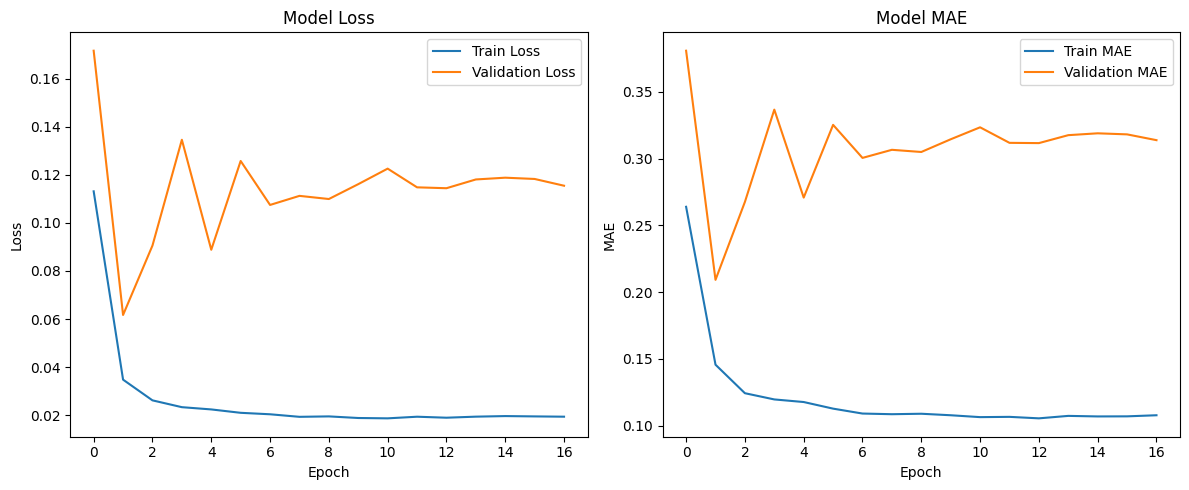


Plotting Predictions vs Actual for Final Model:


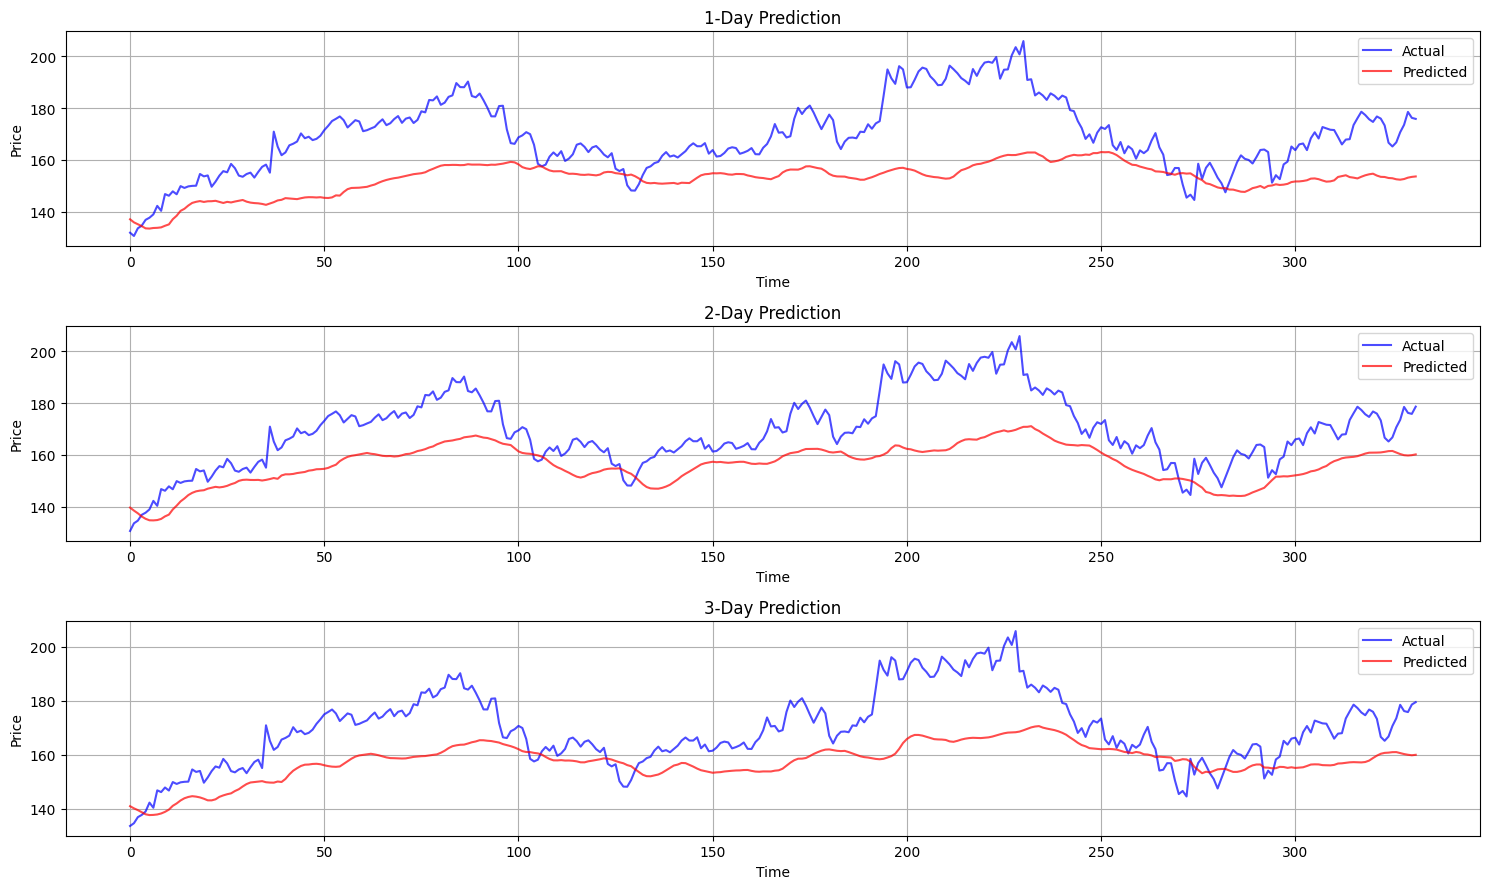


Plotting Error Distribution for Final Model:


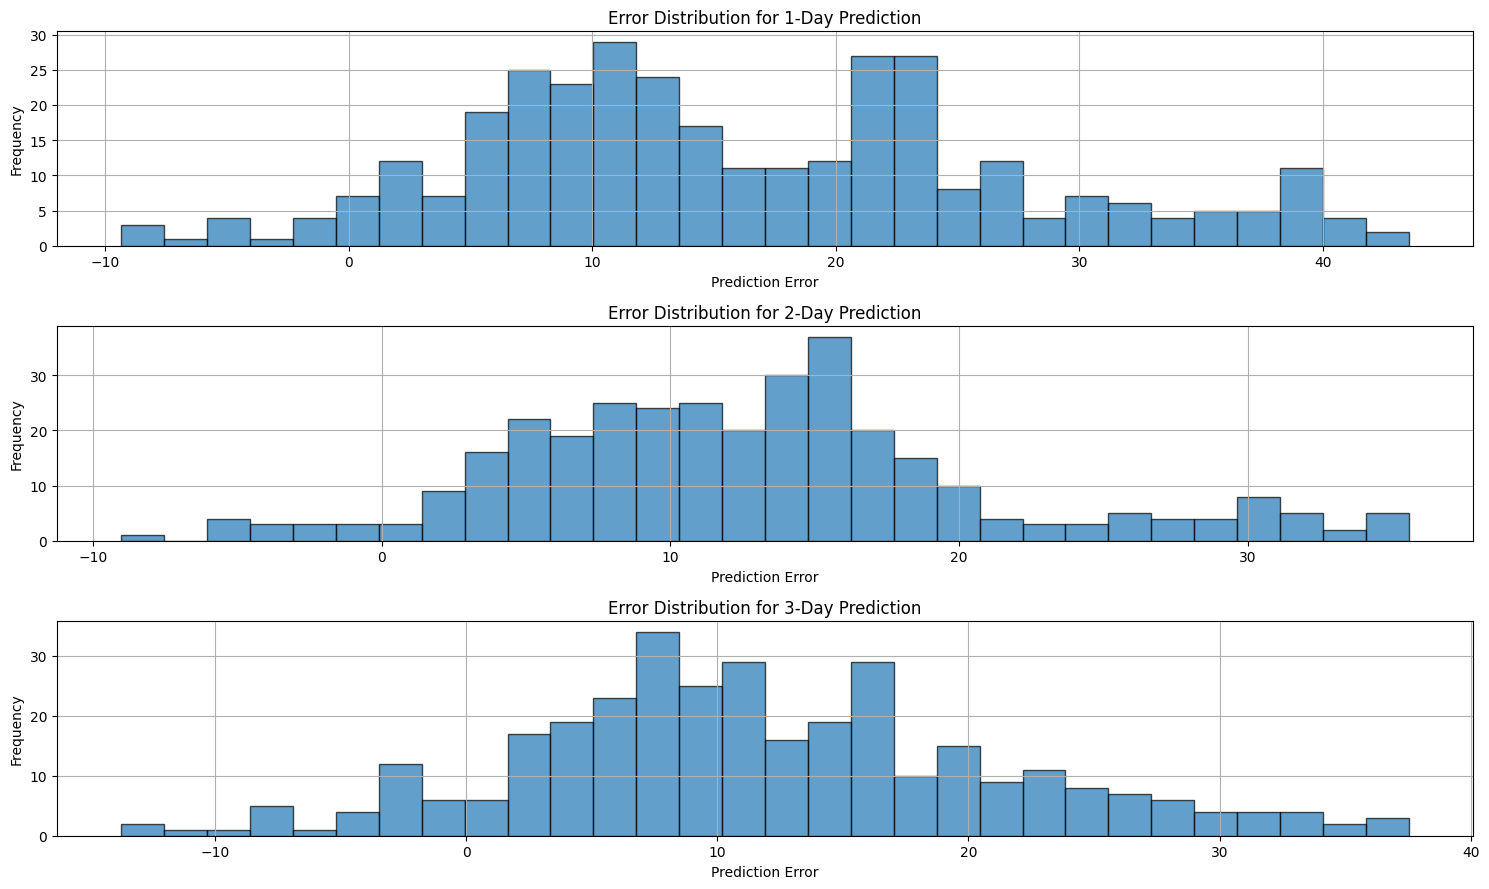


Plotting Market Stress Periods:


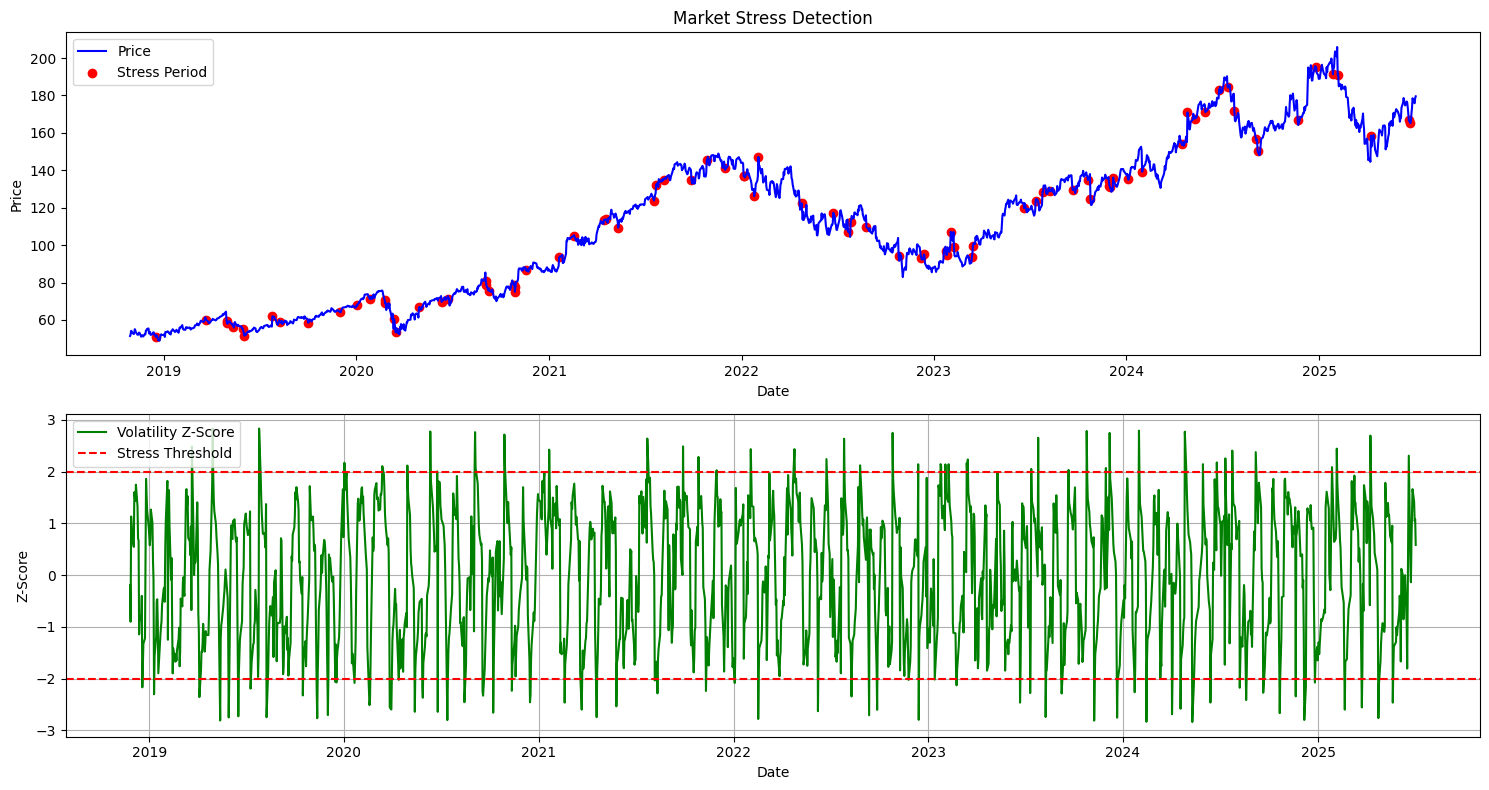


Plotting Prediction Errors During Stress vs Normal Periods:


/var/folders/tb/6mz71wqd5zjdgj1f0dtrpk640000gn/T/ipykernel_14048/3055867069.py:538: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([normal_errors, stress_errors],
/var/folders/tb/6mz71wqd5zjdgj1f0dtrpk640000gn/T/ipykernel_14048/3055867069.py:538: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([normal_errors, stress_errors],
/var/folders/tb/6mz71wqd5zjdgj1f0dtrpk640000gn/T/ipykernel_14048/3055867069.py:538: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([normal_errors, stress_errors],


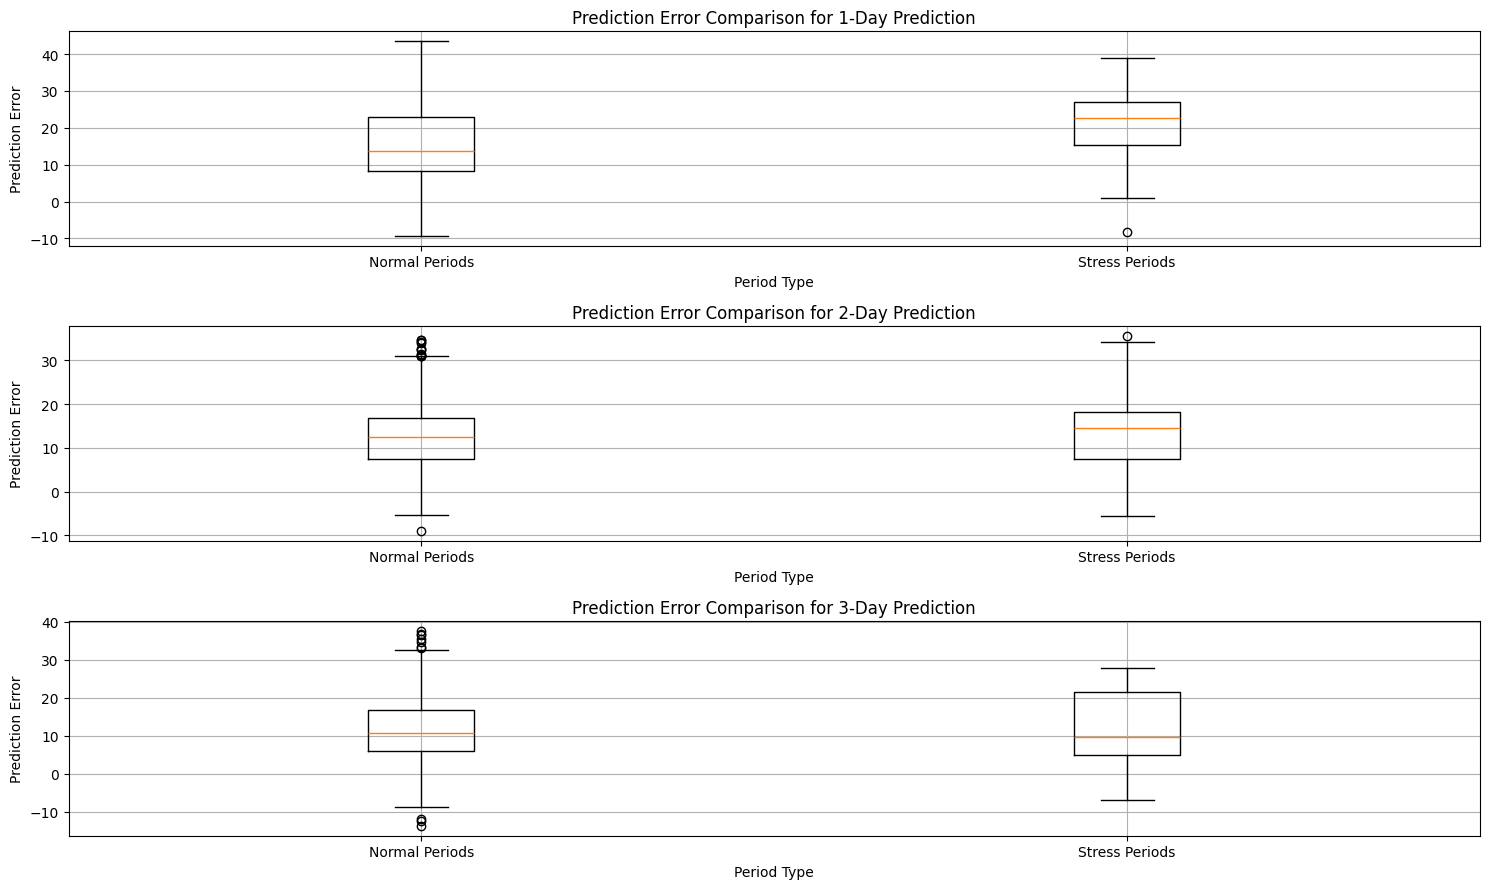


All performance analysis complete for the best model!


In [23]:
import numpy as np
import pandas as pd
import yfinance as yf
import datetime as dt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt

# Import hyperopt components
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials

# --- Settings ---
# These will be the default/maximum values; some will be overridden by hyperopt
N_STEPS = 20
LOOKUP_STEPS = [1, 2, 3] # Predict next 1, 2, and 3 days
STOCK = 'GOOGL'
TEST_SIZE = 0.2
UNITS = 128
DROPOUT = 0.3
BATCH_SIZE = 64
EPOCHS = 200 # Max epochs, EarlyStopping will typically stop sooner
LEARNING_RATE = 0.001
MIN_DATA_LENGTH = 100 # Minimum data points required

# Date range (3 years back from today)
end_date = dt.datetime.now()
start_date = end_date - dt.timedelta(days=2500)

# --- Data Download (Static - run once) ---
try:
    df_raw = yf.download(
        STOCK,
        start=start_date.strftime('%Y-%m-%d'),
        end=end_date.strftime('%Y-%m-%d'),
        interval='1d'
    )
    if df_raw.empty:
        raise ValueError(f"No data found for {STOCK}")
    else:
        print(f"Successfully downloaded {len(df_raw)} days of data for {STOCK}")
except Exception as e:
    print(f"Error downloading data: {e}")
    df_raw=df_backup[['Close']].copy()
    exit()

# Keep only the 'Close' column initially for raw data
df_raw = df_raw[['Close']].copy()

# --- Helper Functions for Data Processing and Model Creation (Dynamic based on params) ---

def add_technical_indicators_dynamic(df, rsi_win, sma10_win, sma30_win, vol_win, macd_e1, macd_e2, macd_sig, min_length=MIN_DATA_LENGTH):
    """
    Adds technical indicators to the DataFrame with dynamic window sizes.
    Ensures window sizes do not exceed available data.
    """
    df_temp = df.copy()
    available_data = len(df_temp)

    # Ensure window sizes are not larger than available data or zero
    # Use max(1, ...) to ensure window size is at least 1
    rsi_win = max(1, min(rsi_win, available_data // 2))
    sma10_win = max(1, min(sma10_win, available_data // 2))
    sma30_win = max(1, min(sma30_win, available_data // 2))
    vol_win = max(1, min(vol_win, available_data // 2))
    macd_e1 = max(1, min(macd_e1, available_data // 2))
    macd_e2 = max(1, min(macd_e2, available_data // 2))
    macd_sig = max(1, min(macd_sig, available_data // 2))
    
    # Simple Moving Averages
    df_temp['SMA_10'] = df_temp['Close'].rolling(window=sma10_win).mean()
    df_temp['SMA_30'] = df_temp['Close'].rolling(window=sma30_win).mean()
    
    # Volatility
    df_temp['Volatility'] = df_temp['Close'].rolling(window=vol_win).std()
    
    # RSI
    delta = df_temp['Close'].diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=rsi_win).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=rsi_win).mean()
    # Handle division by zero for rs, if loss is zero
    with np.errstate(divide='ignore', invalid='ignore'):
        rs = gain / loss
    df_temp['RSI'] = 100 - (100 / (1 + rs))
    df_temp.replace([np.inf, -np.inf], np.nan, inplace=True) # Handle inf values from RSI calculation
    
    # MACD
    exp1 = df_temp['Close'].ewm(span=macd_e1, adjust=False).mean()
    exp2 = df_temp['Close'].ewm(span=macd_e2, adjust=False).mean()
    df_temp['MACD'] = exp1 - exp2
    df_temp['Signal'] = df_temp['MACD'].ewm(span=macd_sig, adjust=False).mean()
    
    # Bollinger Bands (using a fixed or dynamically sized window, or make it a hyperparameter too)
    ma_window_bb = max(1, min(20, available_data // 2)) # You might want to make this a hyperparameter as well
    rolling_mean_bb = df_temp['Close'].rolling(window=ma_window_bb).mean()
    rolling_std_bb = df_temp['Close'].rolling(window=ma_window_bb).std()
    df_temp['Upper_Band'] = rolling_mean_bb + (2 * rolling_std_bb)
    df_temp['Lower_Band'] = rolling_mean_bb - (2 * rolling_std_bb)
    
    # Daily Returns
    df_temp['Daily_Return'] = df_temp['Close'].pct_change()
    
    df_temp.dropna(inplace=True)
    
    if len(df_temp) < min_length:
        raise ValueError(f"After processing, only {len(df_temp)} rows remain. Need at least {min_length} rows.")
    return df_temp

def prepare_dataset_for_model(data, n_steps_val, lookup_steps_val):
    """
    Prepares the dataset into sequences for LSTM.
    """
    X_val, y_val = [], []
    max_step = max(lookup_steps_val)
    
    # Ensure enough data points for sequence creation
    if len(data) < n_steps_val + max_step:
        return np.array([]), np.array([]) # Return empty arrays if not enough data

    for i in range(n_steps_val, len(data) - max_step):
        X_val.append(data[i - n_steps_val:i])
        y_val.append([data[i + step, 0] for step in lookup_steps_val])
    
    return np.array(X_val), np.array(y_val)

def create_lstm_model(sequence_length, n_features, units_val, dropout_val):
    """
    Creates and returns a Keras LSTM model.
    """
    model_val = Sequential()
    model_val.add(LSTM(units=units_val,
                       input_shape=(sequence_length, n_features),
                       return_sequences=True,
                       dropout=dropout_val,
                       recurrent_dropout=dropout_val))
    model_val.add(LSTM(units=int(units_val/2),
                       dropout=dropout_val,
                       recurrent_dropout=dropout_val))
    model_val.add(Dense(units=int(units_val/4), activation='relu'))
    model_val.add(Dropout(dropout_val))
    model_val.add(Dense(len(LOOKUP_STEPS), activation='linear'))
    
    return model_val

# --- Objective Function for Hyperopt ---
def objective(params):
    # Ensure TensorFlow sessions are cleared for fresh model creation
    tf.keras.backend.clear_session()

    # Extract hyperparameters
    n_steps = int(params['n_steps'])
    units = int(params['units'])
    dropout = params['dropout']
    batch_size = int(params['batch_size'])
    learning_rate = params['learning_rate']

    # Indicator parameters
    rsi_window = int(params['rsi_window'])
    sma_10_window = int(params['sma_10_window'])
    sma_30_window = int(params['sma_30_window'])
    vol_window = int(params['vol_window'])
    macd_exp1_window = int(params['macd_exp1_window'])
    macd_exp2_window = int(params['macd_exp2_window'])
    macd_signal_window = int(params['macd_signal_window'])
    
    # Use the globally downloaded raw DataFrame
    df_current_trial = df_raw.copy()

    try:
        df_processed_trial = add_technical_indicators_dynamic(
            df_current_trial,
            rsi_window, sma_10_window, sma_30_window, vol_window,
            macd_exp1_window, macd_exp2_window, macd_signal_window
        )
    except ValueError as e:
        print(f"Skipping trial due to data processing error: {e}. Params: {params}")
        return {'loss': np.inf, 'status': STATUS_OK} # Return high loss for invalid trials

    # Scale the data
    scaler_trial = RobustScaler()
    scaled_data_trial = scaler_trial.fit_transform(df_processed_trial)

    # Prepare the dataset with sequences
    X_trial, y_trial = prepare_dataset_for_model(scaled_data_trial, n_steps, LOOKUP_STEPS)
    
    if len(X_trial) == 0:
        print(f"Skipping trial: Not enough data for sequences with N_STEPS={n_steps}. Available processed data: {len(scaled_data_trial)} points. Params: {params}")
        return {'loss': np.inf, 'status': STATUS_OK}

    # Split into train/test sets
    split_idx_trial = int(len(X_trial) * (1 - TEST_SIZE))
    X_train_trial, X_test_trial = X_trial[:split_idx_trial], X_trial[split_idx_trial:]
    y_train_trial, y_test_trial = y_trial[:split_idx_trial], y_trial[split_idx_trial:]

    # Create and compile the LSTM model
    model_trial = create_lstm_model(
        sequence_length=n_steps,
        n_features=df_processed_trial.shape[1],
        units_val=units,
        dropout_val=dropout
    )

    model_trial.compile(
        optimizer=Adam(learning_rate=learning_rate),
        loss='mean_squared_error',
        metrics=['mae']
    )

    # Callbacks
    callbacks_trial = [
        EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True),
        ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.00001)
    ]

    # Train the model
    history_trial = model_trial.fit(
        X_train_trial, y_train_trial,
        batch_size=batch_size,
        epochs=EPOCHS, # Use a sufficiently large number, EarlyStopping will manage
        validation_data=(X_test_trial, y_test_trial),
        callbacks=callbacks_trial,
        verbose=0 # Set to 0 to avoid verbose output during optimization
    )

    # Evaluate the model on the test set
    y_pred_trial = model_trial.predict(X_test_trial, verbose=0)
    
    # Inverse transform to calculate metrics on original scale
    dummy_array_trial = np.zeros((len(y_test_trial), df_processed_trial.shape[1]))
    
    # Calculate RMSE for the first prediction horizon (1-day) as the optimization metric
    dummy_array_trial[:, 0] = y_test_trial[:, 0] # 1-day actual
    y_test_inv_1day = scaler_trial.inverse_transform(dummy_array_trial)[:, 0]
    
    dummy_array_trial[:, 0] = y_pred_trial[:, 0] # 1-day predicted
    y_pred_inv_1day = scaler_trial.inverse_transform(dummy_array_trial)[:, 0]
    
    rmse = np.sqrt(mean_squared_error(y_test_inv_1day, y_pred_inv_1day))
    mae = mean_absolute_error(y_test_inv_1day, y_pred_inv_1day)

    print(f"Trial completed: RMSE = {rmse:.4f}, MAE = {mae:.4f} with params: {params}")
    return {'loss': rmse, 'status': STATUS_OK}

# --- Define the Search Space ---
space = {
    # Model Hyperparameters
    'n_steps': hp.quniform('n_steps', 10, 50, 5), # Integer between 10 and 50, step 5
    'units': hp.quniform('units', 64, 256, 32), # Integer between 64 and 256, step 32
    'dropout': hp.uniform('dropout', 0.1, 0.5), # Float between 0.1 and 0.5
    'batch_size': hp.quniform('batch_size', 32, 128, 32), # Integer from {32, 64, 96, 128}
    'learning_rate': hp.loguniform('learning_rate', np.log(0.0001), np.log(0.01)), # Log-uniform

    # Indicator Parameters (example ranges, adjust as needed)
    'rsi_window': hp.quniform('rsi_window', 7, 28, 1), # Integer for RSI window
    'sma_10_window': hp.quniform('sma_10_window', 5, 20, 1), # Integer for SMA_10
    'sma_30_window': hp.quniform('sma_30_window', 20, 60, 5), # Integer for SMA_30
    'vol_window': hp.quniform('vol_window', 5, 20, 1), # Integer for Volatility window
    'macd_exp1_window': hp.quniform('macd_exp1_window', 8, 16, 1), # Integer for MACD short EMA
    'macd_exp2_window': hp.quniform('macd_exp2_window', 20, 35, 1), # Integer for MACD long EMA
    'macd_signal_window': hp.quniform('macd_signal_window', 5, 12, 1), # Integer for MACD signal EMA
}

# --- Run Bayesian Optimization ---
print("--- Starting Bayesian Optimization ---")
trials = Trials()
best_params = fmin(
    fn=objective,
    space=space,
    algo=tpe.suggest,
    max_evals=50, # Number of evaluations. Consider increasing for more thorough search (e.g., 100-200)
    trials=trials
)

print("\n--- Optimization Complete ---")
print("Best hyperparameters found:", best_params)

# To get the best RMSE value from the trials
best_rmse_overall = min(trial['result']['loss'] for trial in trials.trials if trial['result']['status'] == STATUS_OK)
print(f"Best RMSE achieved during optimization: {best_rmse_overall:.4f}")

# --- Retrain Model with Best Parameters and Plot Results ---
print("\n--- Training final model with best parameters for visualization ---")

# Extract the best parameters
final_params = best_params

# Ensure Hyperopt's float values are converted to appropriate types for your functions
final_n_steps = int(final_params['n_steps'])
final_units = int(final_params['units'])
final_dropout = final_params['dropout']
final_batch_size = int(final_params['batch_size'])
final_learning_rate = final_params['learning_rate']

final_rsi_window = int(final_params['rsi_window'])
final_sma_10_window = int(final_params['sma_10_window'])
final_sma_30_window = int(final_params['sma_30_window'])
final_vol_window = int(final_params['vol_window'])
final_macd_exp1_window = int(final_params['macd_exp1_window'])
final_macd_exp2_window = int(final_params['macd_exp2_window'])
final_macd_signal_window = int(final_params['macd_signal_window'])

# Re-process data with the best indicator parameters
tf.keras.backend.clear_session() # Clear session before final model build

try:
    df_final_processed = add_technical_indicators_dynamic(
        df_raw, # Use df_raw which is the initially downloaded data
        final_rsi_window, final_sma_10_window, final_sma_30_window, final_vol_window,
        final_macd_exp1_window, final_macd_exp2_window, final_macd_signal_window,
        MIN_DATA_LENGTH
    )
    print(f"Final dataset after processing with best indicator params has {len(df_final_processed)} rows.")
except ValueError as e:
    print(f"Error preparing final data: {e}. Cannot train final model for visualization.")
    exit()

# Scale the final data
final_scaler = RobustScaler()
final_scaled_data = final_scaler.fit_transform(df_final_processed)

# Prepare sequences for the final model
X_final, y_final = prepare_dataset_for_model(final_scaled_data, final_n_steps, LOOKUP_STEPS)

if len(X_final) == 0:
    print("Not enough data to create sequences for final model. Exiting visualization steps.")
    exit()

# Split into train/test sets for the final model
split_idx_final = int(len(X_final) * (1 - TEST_SIZE))
X_train_final, X_test_final = X_final[:split_idx_final], X_final[split_idx_final:]
y_train_final, y_test_final = y_final[:split_idx_final], y_final[split_idx_final:]

# Create the final LSTM model
final_model = create_lstm_model(
    sequence_length=final_n_steps,
    n_features=df_final_processed.shape[1],
    units_val=final_units,
    dropout_val=final_dropout
)

final_model.compile(
    optimizer=Adam(learning_rate=final_learning_rate),
    loss='mean_squared_error',
    metrics=['mae']
)

# Callbacks for final training
final_callbacks = [
    EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.00001)
]

# Train the final model
final_history = final_model.fit(
    X_train_final, y_train_final,
    batch_size=final_batch_size,
    epochs=EPOCHS, # Max epochs for early stopping
    validation_data=(X_test_final, y_test_final),
    callbacks=final_callbacks,
    verbose=1
)

# Evaluate the final model and get inverse transformed predictions
def evaluate_model(model, X_test, y_test, scaler, lookup_steps, df_shape_1):
    y_pred = model.predict(X_test)
    
    dummy_array = np.zeros((len(y_test), df_shape_1))
    
    y_test_orig = []
    y_pred_orig = []
    
    for i in range(len(lookup_steps)):
        dummy_array[:, 0] = y_test[:, i]
        y_test_inv = scaler.inverse_transform(dummy_array)[:, 0]
        
        dummy_array[:, 0] = y_pred[:, i]
        y_pred_inv = scaler.inverse_transform(dummy_array)[:, 0]
        
        y_test_orig.append(y_test_inv)
        y_pred_orig.append(y_pred_inv)
        
        mae = mean_absolute_error(y_test_inv, y_pred_inv)
        rmse = np.sqrt(mean_squared_error(y_test_inv, y_pred_inv))
        r2 = r2_score(y_test_inv, y_pred_inv)
        
        print(f"\nMetrics for {lookup_steps[i]}-day prediction (Final Model):")
        print(f"MAE: {mae:.4f}")
        print(f"RMSE: {rmse:.4f}")
        print(f"R2 Score: {r2:.4f}")
            
    return y_test_orig, y_pred_orig

y_test_orig_final, y_pred_orig_final = evaluate_model(
    final_model, X_test_final, y_test_final, final_scaler, LOOKUP_STEPS, df_final_processed.shape[1]
)

# --- Plotting Functions ---

# 1. Plot training history
def plot_training_history(history):
    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(history.history['mae'], label='Train MAE')
    plt.plot(history.history['val_mae'], label='Validation MAE')
    plt.title('Model MAE')
    plt.ylabel('MAE')
    plt.xlabel('Epoch')
    plt.legend()
    
    plt.tight_layout()
    plt.show()

print("\nPlotting Training History for Final Model:")
plot_training_history(final_history)

# 2. Plot predictions vs actual for each horizon
def plot_predictions(y_test_orig, y_pred_orig, lookup_steps):
    plt.figure(figsize=(15, 3*len(lookup_steps)))
    
    for i, step in enumerate(lookup_steps):
        plt.subplot(len(lookup_steps), 1, i+1)
        plt.plot(y_test_orig[i], label='Actual', color='blue', alpha=0.7)
        plt.plot(y_pred_orig[i], label='Predicted', color='red', alpha=0.7)
        plt.title(f'{step}-Day Prediction')
        plt.xlabel('Time')
        plt.ylabel('Price')
        plt.legend()
        plt.grid(True)
        
    plt.tight_layout()
    plt.show()

print("\nPlotting Predictions vs Actual for Final Model:")
plot_predictions(y_test_orig_final, y_pred_orig_final, LOOKUP_STEPS)

# 3. Plot error distribution
def plot_error_distribution(y_test_orig, y_pred_orig, lookup_steps):
    plt.figure(figsize=(15, 3*len(lookup_steps)))
    
    for i, step in enumerate(lookup_steps):
        errors = y_test_orig[i] - y_pred_orig[i]
        plt.subplot(len(lookup_steps), 1, i+1)
        plt.hist(errors, bins=30, edgecolor='black', alpha=0.7)
        plt.title(f'Error Distribution for {step}-Day Prediction')
        plt.xlabel('Prediction Error')
        plt.ylabel('Frequency')
        plt.grid(True)
        
    plt.tight_layout()
    plt.show()

print("\nPlotting Error Distribution for Final Model:")
plot_error_distribution(y_test_orig_final, y_pred_orig_final, LOOKUP_STEPS)

# 4. Market stress detection and visualization
def detect_market_stress(df, window=10, threshold=2):
    """
    Detect periods of market stress based on volatility and price drops
    
    Parameters:
    - df: DataFrame with price data
    - window: lookback window for stress calculation
    - threshold: number of standard deviations to consider as stress
    
    Returns:
    - DataFrame with stress signals
    """
    df = df.copy()
    df['Returns'] = df['Close'].pct_change()
    df['Volatility'] = df['Returns'].rolling(window).std()
    df['Volatility_Z'] = (df['Volatility'] - df['Volatility'].rolling(window).mean()) / df['Volatility'].rolling(window).std()
    df['Price_Drop'] = df['Close'].pct_change(window)
    df['Drop_Z'] = (df['Price_Drop'] - df['Price_Drop'].rolling(window).mean()) / df['Price_Drop'].rolling(window).std()
    df['Stress_Signal'] = (df['Volatility_Z'] > threshold) | (df['Drop_Z'] < -threshold)
    return df

# Apply stress detection on the *final processed* df to align with model data
df_stress_final = detect_market_stress(df_final_processed)

# Plot stress periods
def plot_stress_periods(df_stress):
    plt.figure(figsize=(15, 8))
    
    plt.subplot(2, 1, 1)
    plt.plot(df_stress.index, df_stress['Close'], label='Price', color='blue')
    stress_periods = df_stress[df_stress['Stress_Signal']]
    plt.scatter(stress_periods.index, stress_periods['Close'], color='red', label='Stress Period')
    plt.title('Market Stress Detection')
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.legend()
    
    plt.subplot(2, 1, 2)
    plt.plot(df_stress.index, df_stress['Volatility_Z'], label='Volatility Z-Score', color='green')
    plt.axhline(y=2, color='red', linestyle='--', label='Stress Threshold')
    plt.axhline(y=-2, color='red', linestyle='--')
    plt.xlabel('Date')
    plt.ylabel('Z-Score')
    plt.legend()
    plt.grid(True)
    
    plt.tight_layout()
    plt.show()

print("\nPlotting Market Stress Periods:")
plot_stress_periods(df_stress_final)

# 5. Plot prediction errors during stress vs normal periods
def plot_stress_errors(df_stress, y_test_orig, y_pred_orig, lookup_steps):
    # Align stress signals with test periods of the processed dataframe
    test_dates = df_stress.index[-len(y_test_orig[0]):]
    test_stress = df_stress.loc[test_dates, 'Stress_Signal']
    
    plt.figure(figsize=(15, 3*len(lookup_steps)))
    
    for i, step in enumerate(lookup_steps):
        errors = y_test_orig[i] - y_pred_orig[i]
        
        # Use .values to ensure correct boolean indexing in case of index misalignment
        stress_errors = errors[test_stress.values]
        normal_errors = errors[~test_stress.values]
        
        plt.subplot(len(lookup_steps), 1, i+1)
        plt.boxplot([normal_errors, stress_errors], 
                   labels=['Normal Periods', 'Stress Periods'])
        plt.title(f'Prediction Error Comparison for {step}-Day Prediction')
        plt.ylabel('Prediction Error')
        plt.xlabel('Period Type')
        plt.grid(True)
        
    plt.tight_layout()
    plt.show()

print("\nPlotting Prediction Errors During Stress vs Normal Periods:")
plot_stress_errors(df_stress_final, y_test_orig_final, y_pred_orig_final, LOOKUP_STEPS)

print("\nAll performance analysis complete for the best model!")